# Import libraries

In [5]:
import pandas as pd
#pd.options.mode.chained_assignment = None
import numpy as np
import re
import sklearn
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score, roc_curve, roc_auc_score, precision_score, recall_score, accuracy_score
from sklearn import metrics
from sklearn.svm import SVC
from collections import Counter
#from xgboost import XGBClassifier
import itertools as it
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as py
import matplotlib.pyplot as plt
import seaborn as sns
from lime.lime_tabular import LimeTabularExplainer


In [6]:
figsize=(13,5)
r_seed=123

# Some useful user defined functions

Some function that we'll use during this project

In [7]:
print_= True

def first_report(df):
    
        
        describe = df.describe(include='all').T
        describe['Types']=df.dtypes
        describe['Missing Values']=len(df) - df.count()
        
        #ad hoc addings and removings:
        describe['Classes']=[set(df[col]) for col in df.columns]
    
        describe.drop(columns=['std','min','25%','50%','75%',], inplace=True)
        
        
        types_na = pd.DataFrame({'Types':df.dtypes,
                               'Nas':len(df) - df.count()})
        if print_:
            print(f'Columns:{df.shape[1]}\nRows:{df.shape[0]}')
            with pd.option_context('display.max_rows', None, 'display.max_columns', None):
                display(describe.T)
        
def pieplotly(df, var):
    #labels
    lab = df[var].value_counts().keys().tolist()
    #values
    val = df[var].value_counts().values.tolist()
    
    trace = go.Pie(labels = lab ,
                   values = val ,
                   marker = dict(colors =  [ 'blue' ,'orange'],
                                 line = dict(color = "white",
                                             width =  1.3)
                                ),
                   rotation = 90,
                   hoverinfo = "label+value+text",
                   hole = 0
                  )
    
    layout = go.Layout(dict(title = "Customer Churn in data",
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                           )
                      )
    
    data = [trace]
    fig = go.Figure(data = data,layout = layout)
    py.iplot(fig)

    
def printall(df):
    if print_:
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):
            display(df)
            


def Cat_vs_target(df, target, target_value, key, categorical_var, only_plot=True,figsize=figsize):
    #sia si che no
    yes_and_no = df.groupby([categorical_var,target])[[key]].count()
   
    
    #solo si
    only_yes = df.loc[df[target]==target_value].groupby([categorical_var])[[key]].count()
    
    
    #si e no sommati per ogni Number_of_services
    count = df.groupby([categorical_var])[[key]].count()
    
    
    #proporzione di churn=yes per ogni Number_of_services
    prop = df.loc[df[target]==target_value].groupby([categorical_var])[[key]].count()/df.groupby([categorical_var])[[key]].count()
    
    #rename
   
    prop.rename(columns={"customerID": 'Churn proportion'}, inplace=True)
    yes_and_no.rename(columns={"customerID": 'Customers'}, inplace=True)
    only_yes.rename(columns={"customerID": 'Churn: yes'}, inplace=True)
    count.rename(columns={"customerID": 'Customers'}, inplace=True)
    
    #visualizzazione di churn per Number_of_services
    prop.plot.bar(figsize=figsize, legend=None)
    
    if not only_plot:
        return yes_and_no, only_yes, count, prop

In [8]:
def Num_vs_Target(df, target): 
    numerical_varibles=df.columns
    for x in numerical_variables:
        print(x)
        for cl in set(df[target]):
            
            df.loc[df[target]==cl, x].plot.density(figsize=(10,6 ))           
            
        plt.show()

In [9]:
def scatterplot3d(df, x, y, z, color):
    fig = px.scatter_3d(df, 
                        x=df[x], 
                        y=df[y], 
                        z=df[z],
                        color=df[color])

    fig.update_traces(marker=dict(size=3),
                      selector=dict(mode='markers'))

    fig.show()

In [10]:
def mean_encoding(df, col, target, smooth=False, m=10):

    means = df.groupby(col)[target].mean()

    if smooth:
        counts = df.groupby(col)[target].count()
        mean = df[target].mean()
        means = (counts * means + m * mean) / (counts + m)

    return df[col].map(means), means.to_dict()

In [11]:
def Correlations(data,target):
    plt.figure(figsize = (20,15))
    corr_matrix = data.corr()
    matrix = np.triu(data.corr())
    sns.heatmap(corr_matrix, xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns, linewidths=.2, cmap="coolwarm")
    plt.show()
    couples = {}
    drop_c = []
    for i, r in corr_matrix.iterrows():
        for j, x in r.iteritems():
            if i != j and np.abs(x) > 0.9 and i not in drop_c and j not in drop_c:
                couples[(i, j)] = (corr_matrix.loc[i, j], corr_matrix.loc[i, target], corr_matrix.loc[j, target])
                if np.abs(corr_matrix.loc[j, target])>np.abs(corr_matrix.loc[i, target]):
                    drop_c.append(i)
                else:
                    drop_c.append(j)
    return pd.DataFrame(couples).T, drop_c

In [12]:
def results(cv):
    parameters = cv.cv_results_['params']
    table = pd.DataFrame.from_dict(parameters)
    table['mean_train_score'] = cv.cv_results_['mean_train_score']
    table['mean_test_score'] = cv.cv_results_['mean_test_score']
    
    return table

# Data importing:

After a quick inspection of the csv we realized that the NaS were coded as ' '. So we set the parameter na_values to that string.

In [13]:
path_df = 'TelcoChurn.csv'
df = pd.read_csv(path_df,
                na_values=' ')
printall(df.head())

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1              Yes          No          No              No        One year   
2               No          No          No              No  Month-to-month   
3              Yes         Yes          No              No        One year   
4               No          No          No              No  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges  TotalCharges  \
0              Yes           Electronic check           29.85         29.85   
1               No               Mailed check           56.95       1889.50   
2              Yes               Mailed check           53.85        108.15   
3               No  Bank transfer (automatic)           42.30       1840.75   
4              Yes           Electronic check           70.70        151.65   

  Churn  
0    No  
1    No  
2   Yes  
3    No  
4   Yes

In [14]:
explain = {
'customerID': 'Customer ID',
'gender': 'Whether the customer is a male or a female',
'SeniorCitizen': 'Whether the customer is a senior citizen or not (1, 0)',
'Partner': 'Whether the customer has a partner or not (Yes, No)',
'Dependents': 'Whether the customer has dependents or not (Yes, No)',
'tenure': 'Number of months the customer has stayed with the company',
'PhoneService': 'Whether the customer has a phone service or not (Yes, No)',
'MultipleLines': 'Whether the customer has multiple lines or not (Yes, No, No phone service)',
'InternetService': 'Customer’s internet service provider (DSL, Fiber optic, No)',
'OnlineSecurity': 'Whether the customer has online security or not (Yes, No, No internet service)',
'OnlineBackup': 'Whether the customer has online backup or not (Yes, No, No internet service)',
'DeviceProtection': 'Whether the customer has device protection or not (Yes, No, No internet service)',
'TechSupport': 'Whether the customer has tech support or not (Yes, No, No internet service)',
'StreamingTV': 'Whether the customer has streaming TV or not (Yes, No, No internet service)',
'StreamingMovies': 'Whether the customer has streaming movies or not (Yes, No, No internet service)',
'Contract': 'The contract term of the customer (Month-to-month, One year, Two year)',
'PaperlessBilling': 'Whether the customer has paperless billing or not (Yes, No)',
'PaymentMethod': 'The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))',
'MonthlyCharges': 'The amount charged to the customer monthly',
'TotalCharges': 'The total amount charged to the customer',
'Churn': 'Whether the customer churned or not (Yes or No)',
}

In [15]:
explain["MonthlyCharges"]

'The amount charged to the customer monthly'

## Dataset overview:

In [16]:
first_report(df)

Columns:21
Rows:7043


customerID  \
count                                                        7043   
unique                                                       7043   
top                                                    2072-ZVJJX   
freq                                                            1   
mean                                                          NaN   
max                                                           NaN   
Types                                                      object   
Missing Values                                                  0   
Classes         {8024-XNAFQ, 6616-AALSR, 1447-PJGGA, 9961-JBNM...   

                        gender SeniorCitizen    Partner Dependents  \
count                     7043          7043       7043       7043   
unique                       2           NaN          2          2   
top                       Male           NaN         No         No   
freq                      3555           NaN       3641       4933   
mean                       NaN      0.162147        NaN        NaN   
max                        NaN             1        NaN        NaN   
Types                   object         int64     object     object   
Missing Values               0             0          0          0   
Classes         {Male, Female}        {0, 1}  {No, Yes}  {No, Yes}   

                                                           tenure  \
count                                                        7043   
unique                                                        NaN   
top                                                           NaN   
freq                                                          NaN   
mean                                                      32.3711   
max                                                            72   
Types                                                       int64   
Missing Values                                                  0   
Classes         {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   

               PhoneService                MultipleLines  \
count                  7043                         7043   
unique                    2                            3   
top                     Yes                           No   
freq                   6361                         3390   
mean                    NaN                          NaN   
max                     NaN                          NaN   
Types                object                       object   
Missing Values            0                            0   
Classes           {No, Yes}  {No, Yes, No phone service}   

                       InternetService                  OnlineSecurity  \
count                             7043                            7043   
unique                               3                               3   
top                        Fiber optic                              No   
freq                              3096                            3498   
mean                               NaN                             NaN   
max                                NaN                             NaN   
Types                           object                          object   
Missing Values                       0                               0   
Classes         {No, Fiber optic, DSL}  {No, Yes, No internet service}   

                                  OnlineBackup  \
count                                     7043   
unique                                       3   
top                                         No   
freq                                      3088   
mean                                       NaN   
max                                        NaN   
Types                                   object   
Missing Values                               0   
Classes         {No, Yes, No internet service}   

                              DeviceProtection  \
count                                     7043   
unique                       

The dataset consists of 7043 observations and it has 21 variables.
The total number of Nas is 11 and all are related to the TotalCharges variable.

Basically we have three options:

- _drop them_ ;

- _substitute them with the average/mode_ ;

- _subsitute them with 0_ ;

In [17]:
printall(
df.loc[df["TotalCharges"].isna()]
)

customerID  gender  SeniorCitizen Partner Dependents  tenure  \
488   4472-LVYGI  Female              0     Yes        Yes       0   
753   3115-CZMZD    Male              0      No        Yes       0   
936   5709-LVOEQ  Female              0     Yes        Yes       0   
1082  4367-NUYAO    Male              0     Yes        Yes       0   
1340  1371-DWPAZ  Female              0     Yes        Yes       0   
3331  7644-OMVMY    Male              0     Yes        Yes       0   
3826  3213-VVOLG    Male              0     Yes        Yes       0   
4380  2520-SGTTA  Female              0     Yes        Yes       0   
5218  2923-ARZLG    Male              0     Yes        Yes       0   
6670  4075-WKNIU  Female              0     Yes        Yes       0   
6754  2775-SEFEE    Male              0      No        Yes       0   

     PhoneService     MultipleLines InternetService       OnlineSecurity  \
488            No  No phone service             DSL                  Yes   
753           Yes                No              No  No internet service   
936           Yes                No             DSL                  Yes   
1082          Yes               Yes              No  No internet service   
1340           No  No phone service             DSL                  Yes   
3331          Yes                No              No  No internet service   
3826          Yes               Yes              No  No internet service   
4380          Yes                No              No  No internet service   
5218          Yes                No              No  No internet service   
6670          Yes               Yes             DSL                   No   
6754          Yes               Yes             DSL                  Yes   

             OnlineBackup     DeviceProtection          TechSupport  \
488                    No                  Yes                  Yes   
753   No internet service  No internet service  No internet service   
936                   Yes                  Yes                   No   
1082  No internet service  No internet service  No internet service   
1340                  Yes                  Yes                  Yes   
3331  No internet service  No internet service  No internet service   
3826  No internet service  No internet service  No internet service   
4380  No internet service  No internet service  No internet service   
5218  No internet service  No internet service  No internet service   
6670                  Yes                  Yes                  Yes   
6754                  Yes                   No                  Yes   

              StreamingTV      StreamingMovies  Contract PaperlessBilling  \
488                   Yes                   No  Two year              Yes   
753   No internet service  No internet service  Two year               No   
936                   Yes                  Yes  Two year               No   
1082  No internet service  No internet service  Two year               No   
1340                  Yes                   No  Two year               No   
3331  No internet service  No internet service  Two year               No   
3826  No internet service  No internet service  Two year               No   
4380  No internet service  No internet service  Two year               No   
5218  No internet service  No internet service  One year              Yes   
6670                  Yes                   No  Two year               No   
6754                   No                   No  Two year              Yes   

                  PaymentMethod  MonthlyCharges  TotalCharges Churn  
488   Bank transfer (automatic)           52.55           NaN    No  
753                Mailed check           20.25           NaN    No  
936                Mailed check           80.85           NaN    No  
1082               Mailed check           25.75           NaN    No  
1340    Credit card (automatic)           56.05           NaN    No  
3331               Mailed check           19.85       

If we look at MonthlyCharges, tenure, TotalCharges, and Churn, we can see that all of these individuals had a tenure of 0. This means they have not yet been with the company for a whole month, and therefore have not yet been charged any money. This explains why TotalCharges is missing, and also why none of them have churned yet.
At this point we decided to safely remove these observations from our model given the fact that 11 observation represents just the 0,1% of the dataset.

In [18]:
df.dropna(axis = 0, how = 'any', inplace = True)
df.reset_index(drop=True,inplace=True)

In [19]:
df["TotalCharges"].isna().sum()

0

### Dealing with categorical services

Another significant issue is that variables related to services have three different categories ("Yes","No", "No Internet Service" or "No Phone Service"). We decided to consider "No Internet Service" and "No Phone Service" as "No" because we thought that this information was redundant for our analysis. The information given by those classes are arleady given by the variables "Phone Service" and "Internet Service".

In [20]:
replace_cols = [ 
    'OnlineSecurity', 
    'OnlineBackup', 
    'DeviceProtection',
    'TechSupport',
    'StreamingTV', 
    'StreamingMovies',
    'MultipleLines'
]

for i in replace_cols : 
    df[i]  = df[i].replace({'No internet service' : 'No',
                            'No phone service':'No'})

# Exploratory Data Analysis

## Target Distribution:

In [21]:
pieplotly(df, "Churn")

###### With this plot we can see that our dataset is unbalanced. 

## Categorical variables

Let's have a brief look at all the categorical variables:

In [22]:
categorical_variables = [
"gender",
"SeniorCitizen",
"Partner",
"Dependents",
"PhoneService",
"MultipleLines",
"InternetService",
"OnlineSecurity",
"OnlineBackup",
"DeviceProtection",
"TechSupport",
"StreamingTV",
"StreamingMovies",
"Contract",
"PaperlessBilling",
"PaymentMethod",
]

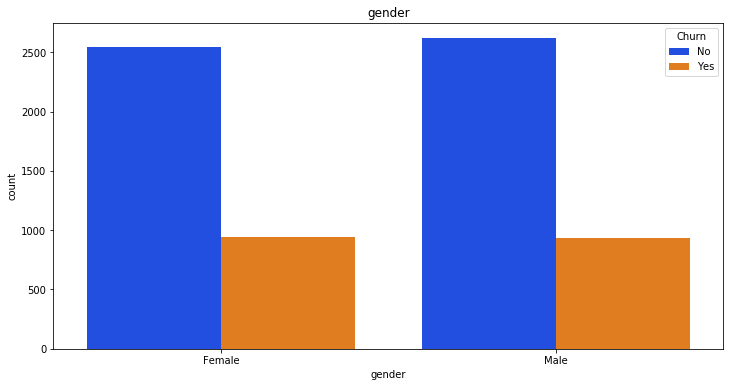

Explaination:
 Whether the customer is a male or a female




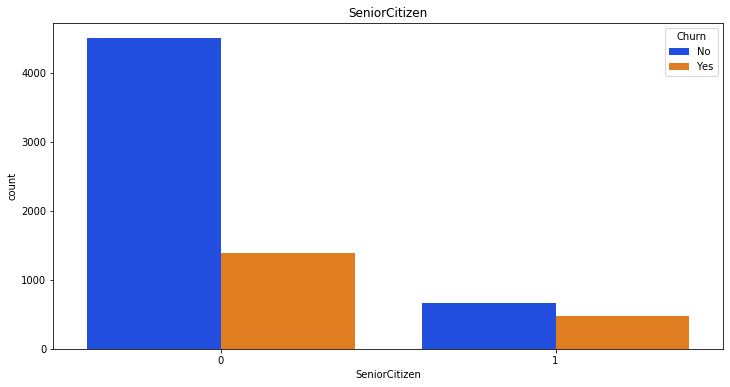

Explaination:
 Whether the customer is a senior citizen or not (1, 0)




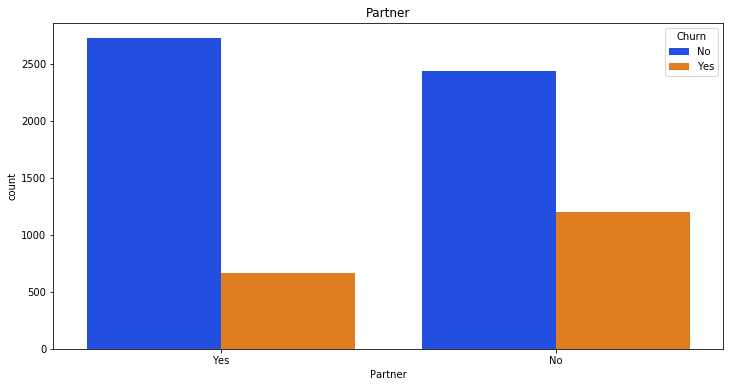

Explaination:
 Whether the customer has a partner or not (Yes, No)




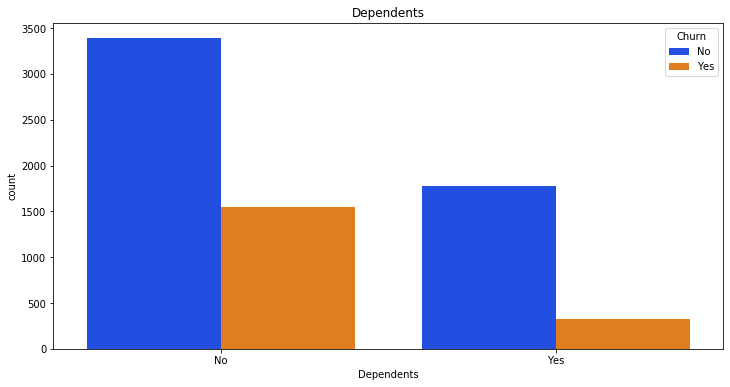

Explaination:
 Whether the customer has dependents or not (Yes, No)




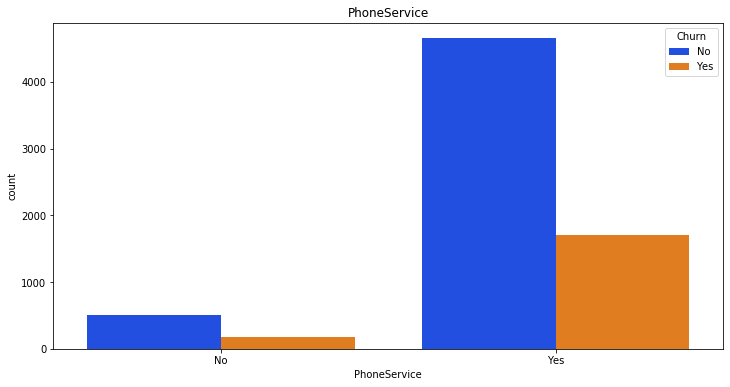

Explaination:
 Whether the customer has a phone service or not (Yes, No)




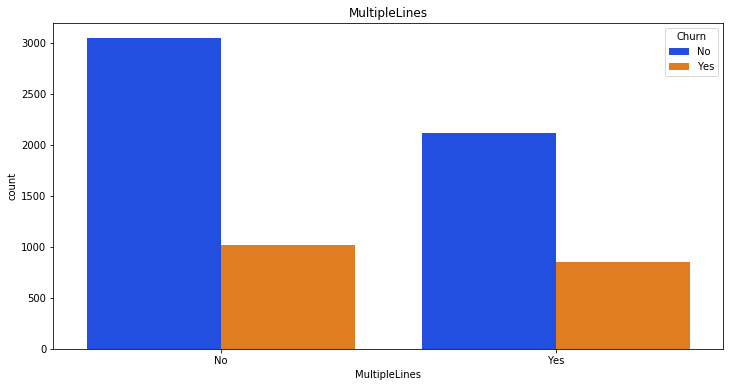

Explaination:
 Whether the customer has multiple lines or not (Yes, No, No phone service)




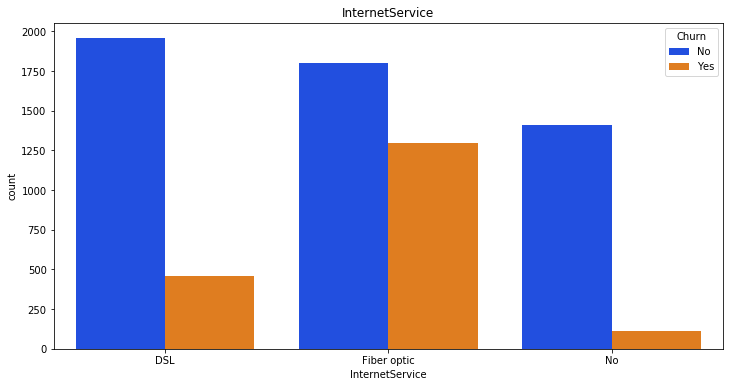

Explaination:
 Customer’s internet service provider (DSL, Fiber optic, No)




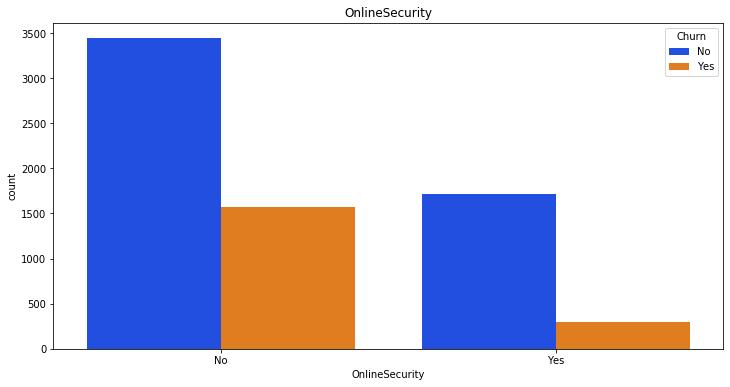

Explaination:
 Whether the customer has online security or not (Yes, No, No internet service)




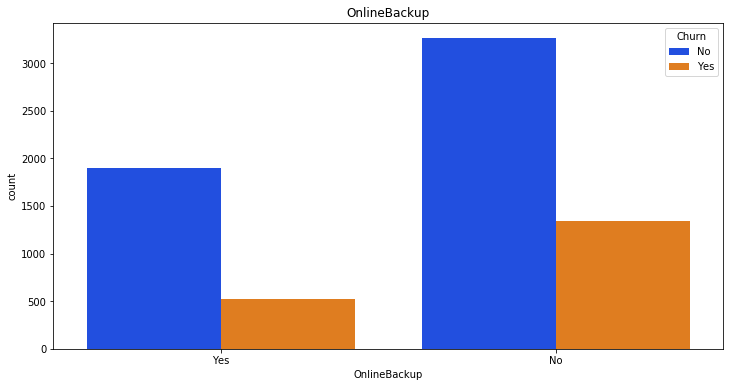

Explaination:
 Whether the customer has online backup or not (Yes, No, No internet service)




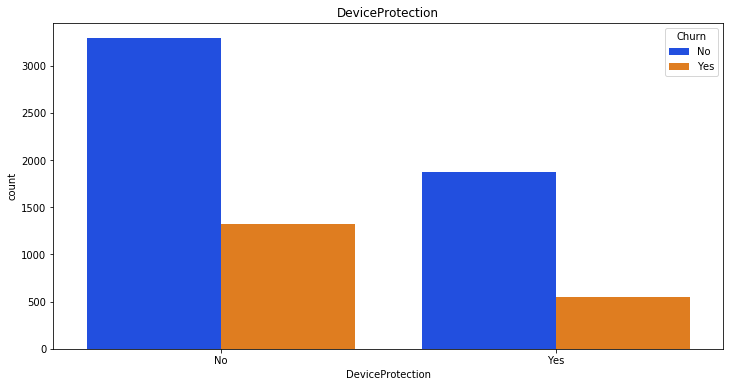

Explaination:
 Whether the customer has device protection or not (Yes, No, No internet service)




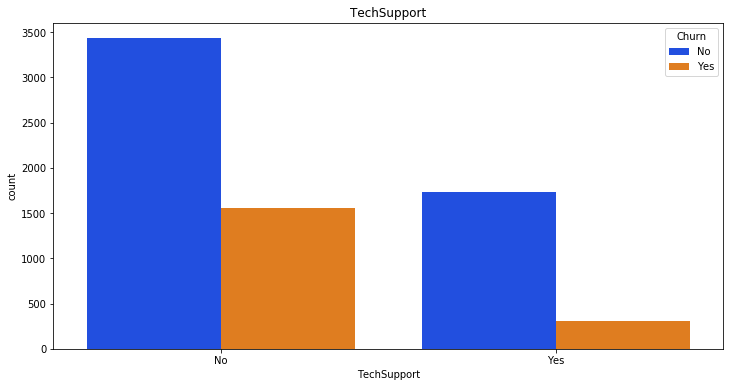

Explaination:
 Whether the customer has tech support or not (Yes, No, No internet service)




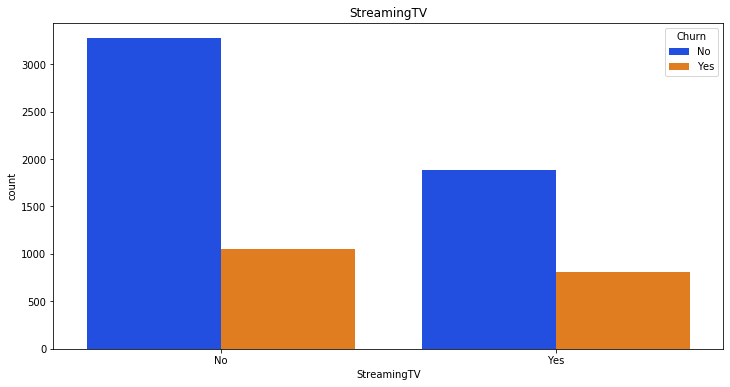

Explaination:
 Whether the customer has streaming TV or not (Yes, No, No internet service)




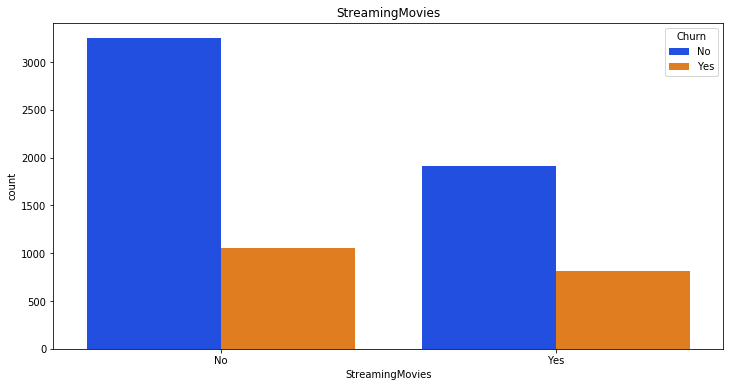

Explaination:
 Whether the customer has streaming movies or not (Yes, No, No internet service)




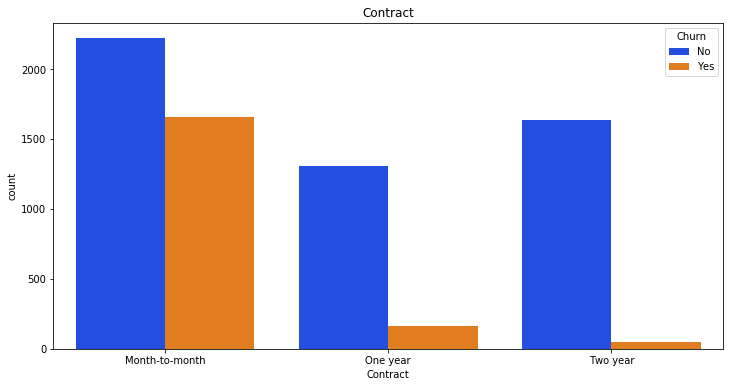

Explaination:
 The contract term of the customer (Month-to-month, One year, Two year)




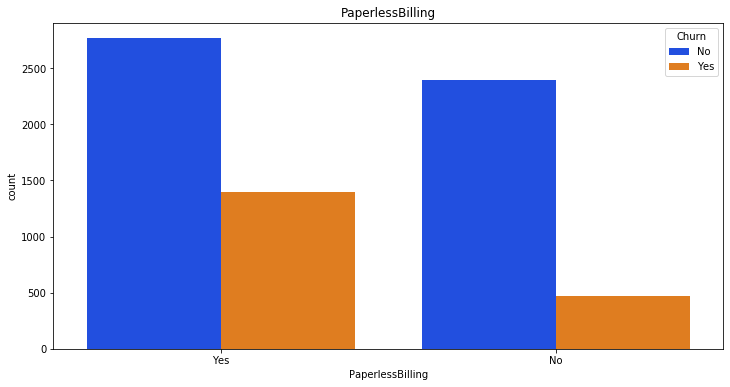

Explaination:
 Whether the customer has paperless billing or not (Yes, No)




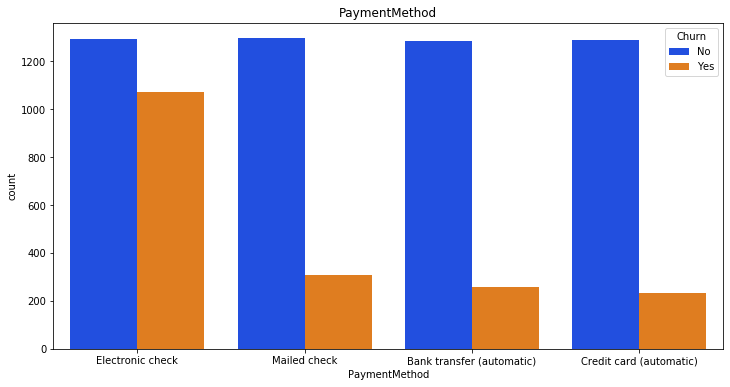

Explaination:
 The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))




In [23]:
for var in df[categorical_variables].columns:
    plt.figure(figsize = (12,6))
    g = sns.countplot(x=df.loc[:,var], hue=df["Churn"], palette = "bright")
    plt.title(var)
    plt.show()
    print(f'Explaination:\n {explain[var]}\n\n')

##### After a visual inspection let's focus on the "interesting" variables:

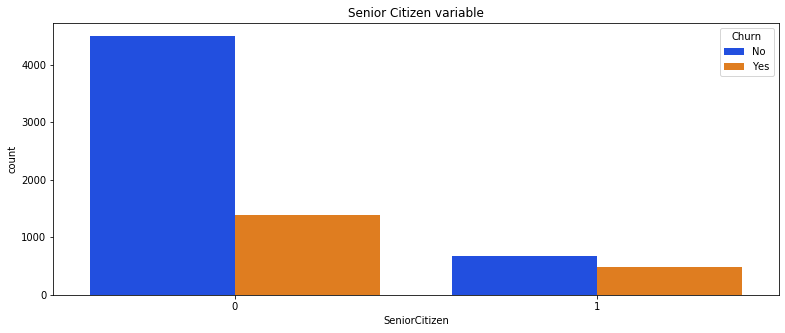

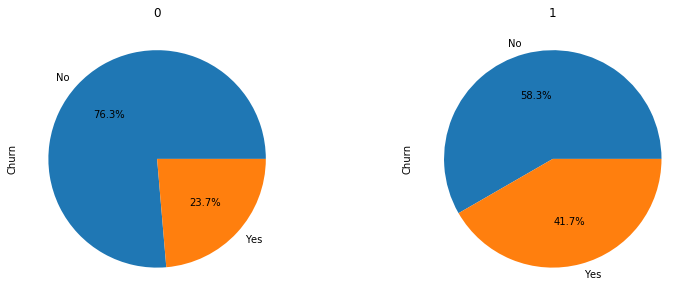

In [24]:
plt.figure(figsize = figsize)
g = sns.countplot(x=df.loc[:,"SeniorCitizen"], hue=df["Churn"], palette = "bright")
plt.title("Senior Citizen variable")
plt.show()
classes = set(df["SeniorCitizen"])
for cl_index, cl in enumerate(classes):
            
    plt.subplot(int(str(1)+str(len(classes))+str(cl_index+1))).set_title(cl)
            
    df.loc[df["SeniorCitizen"]==cl]["Churn"].value_counts().plot.pie(figsize=figsize,autopct='%1.1f%%',)


#### Notes:
> We can visually see that older client are less than young clients, but the proportion of churning older clients is bigger

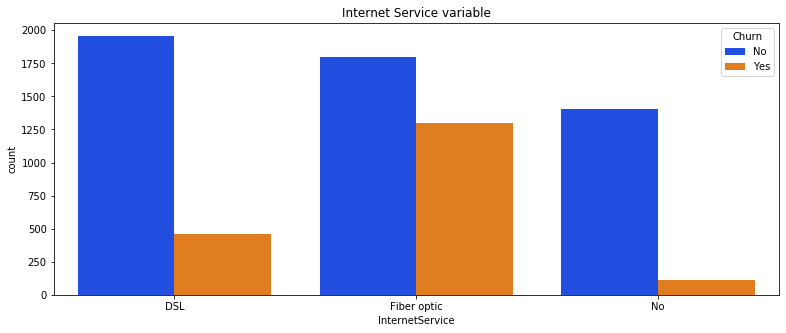

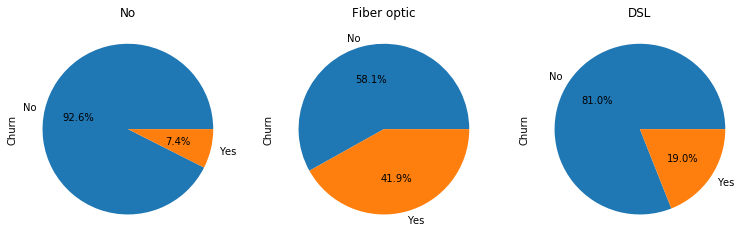

In [25]:
plt.figure(figsize = figsize)
g = sns.countplot(x=df.loc[:,"InternetService"], hue=df["Churn"], palette = "bright")
plt.title("Internet Service variable")
plt.show()
classes = set(df["InternetService"])
for cl_index, cl in enumerate(classes):
            
    plt.subplot(int(str(1)+str(len(classes))+str(cl_index+1))).set_title(cl)
    
    df.loc[df["InternetService"]==cl]["Churn"].value_counts().plot.pie(figsize=figsize,autopct='%1.1f%%')

#### Notes:
> The clients with fiber optic have a significant percentage of churning rate, about 42%

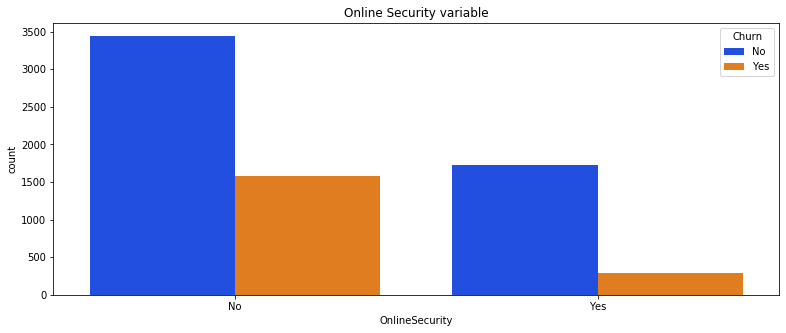

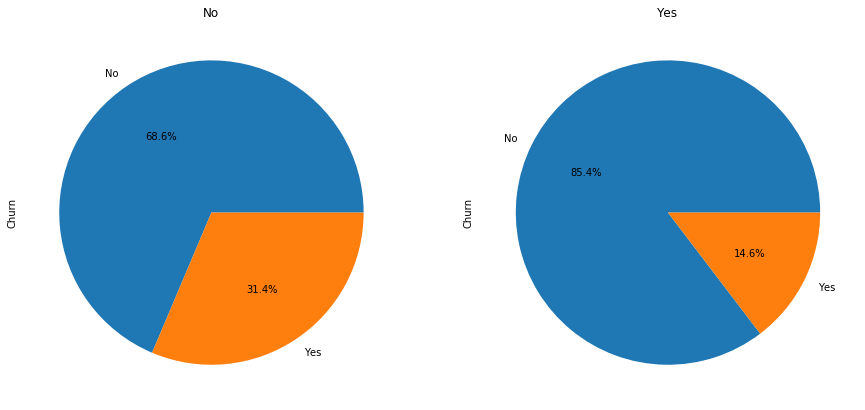

In [26]:
plt.figure(figsize = figsize)
g = sns.countplot(x=df.loc[:,"OnlineSecurity"], hue=df["Churn"], palette = "bright")
plt.title("Online Security variable")
plt.show()
classes = set(df["OnlineSecurity"])
for cl_index, cl in enumerate(classes):
            
    plt.subplot(int(str(1)+str(len(classes))+str(cl_index+1))).set_title(cl)
            
    df.loc[df["OnlineSecurity"]==cl]["Churn"].value_counts().plot.pie(figsize=(15,15),autopct='%1.1f%%')


#### Notes:
> Clients that don't have security have higher churning rate with respect to those that don't have it

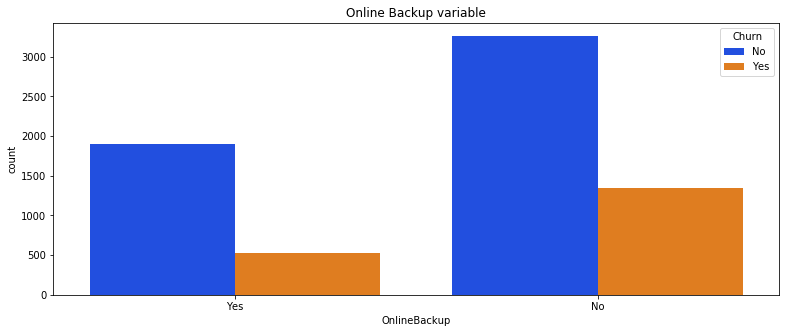

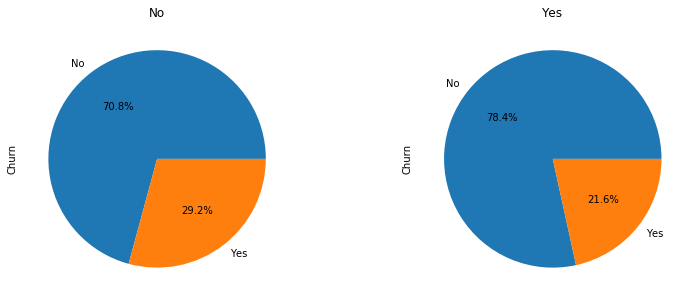

In [27]:
plt.figure(figsize = figsize)
g = sns.countplot(x=df.loc[:,"OnlineBackup"], hue=df["Churn"], palette = "bright")
plt.title("Online Backup variable")
plt.show()
classes = set(df["OnlineBackup"])
for cl_index, cl in enumerate(classes):
            
    plt.subplot(int(str(1)+str(len(classes))+str(cl_index+1))).set_title(cl)
            
    df.loc[df["OnlineBackup"]==cl]["Churn"].value_counts().plot.pie(figsize=figsize,autopct='%1.1f%%')

#### Notes:
> Clients that don't have online backup service have higher churning rate

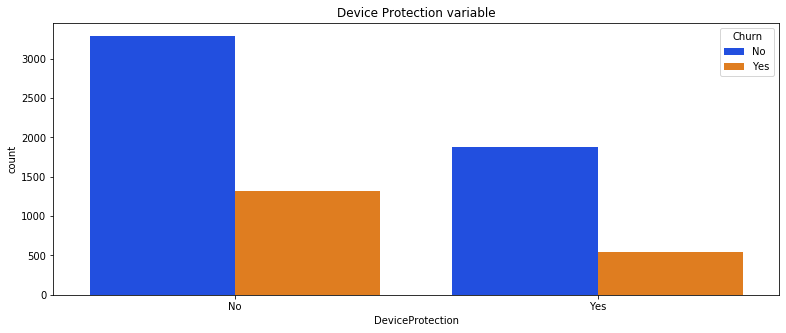

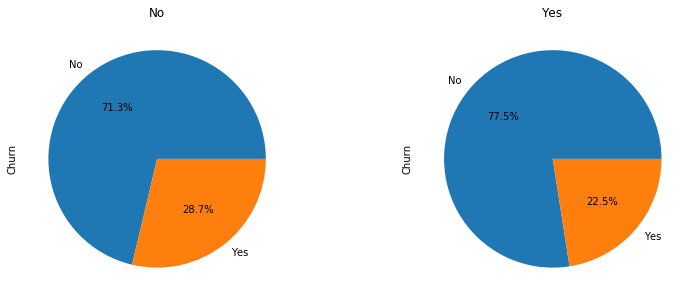

In [28]:
plt.figure(figsize = figsize)
g = sns.countplot(x=df.loc[:,"DeviceProtection"], hue=df["Churn"], palette = "bright")
plt.title("Device Protection variable")
plt.show()
classes = set(df["DeviceProtection"])
for cl_index, cl in enumerate(classes):
            
    plt.subplot(int(str(1)+str(len(classes))+str(cl_index+1))).set_title(cl)
            
    df.loc[df["DeviceProtection"]==cl]["Churn"].value_counts().plot.pie(figsize=figsize,autopct='%1.1f%%')


### Notes:
> Clients that don't have device protection service have higher churning rate

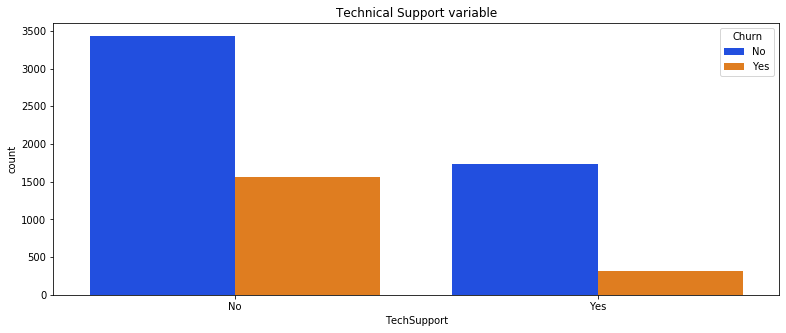

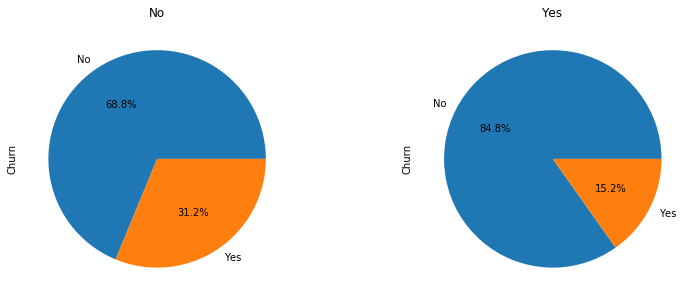

In [29]:
plt.figure(figsize = figsize)
g = sns.countplot(x=df.loc[:,"TechSupport"], hue=df["Churn"], palette = "bright")
plt.title("Technical Support variable")
plt.show()
classes = set(df["TechSupport"])
for cl_index, cl in enumerate(classes):
            
    plt.subplot(int(str(1)+str(len(classes))+str(cl_index+1))).set_title(cl)
            
    df.loc[df["TechSupport"]==cl]["Churn"].value_counts().plot.pie(figsize=figsize,autopct='%1.1f%%')


#### Notes:
> Clients that don't have techincal support service have higher churning rate

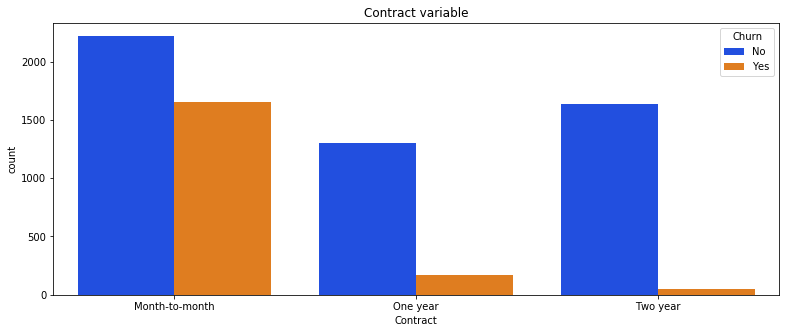

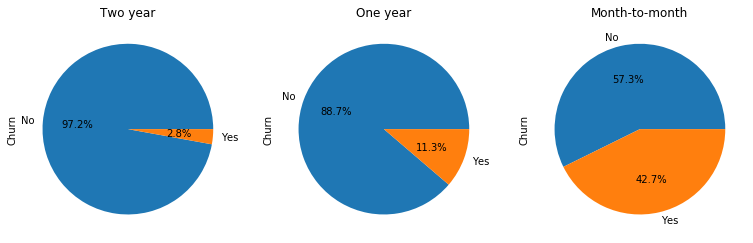

In [30]:
plt.figure(figsize = figsize)
g = sns.countplot(x=df.loc[:,"Contract"], hue=df["Churn"], palette = "bright")
plt.title("Contract variable")
plt.show()
classes = set(df["Contract"])
for cl_index, cl in enumerate(classes):
            
    plt.subplot(int(str(1)+str(len(classes))+str(cl_index+1))).set_title(cl)
            
    df.loc[df["Contract"]==cl]["Churn"].value_counts().plot.pie(figsize=figsize,autopct='%1.1f%%')

#### Notes:
> Here we can see that the monthly contract has the highest churn rate. More "loyal" clients (in terms of contract type) tend to churn less

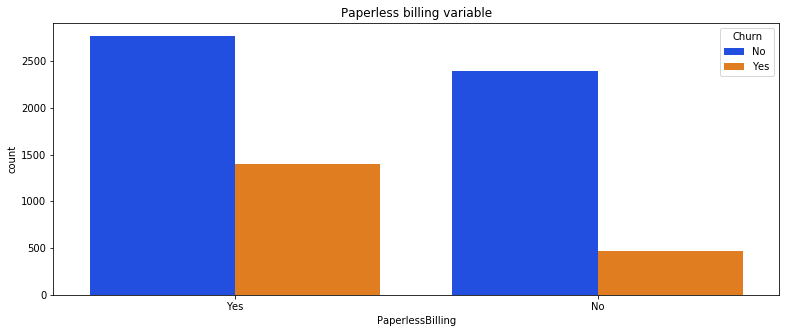

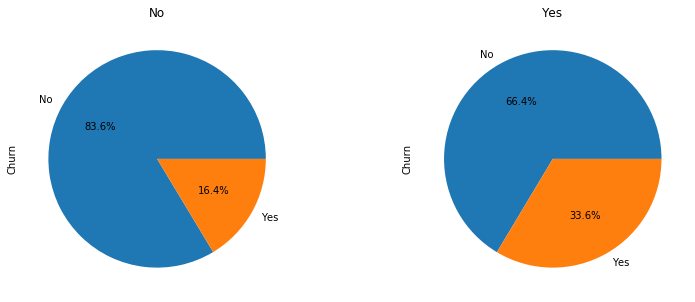

In [31]:
plt.figure(figsize = figsize)
g = sns.countplot(x=df.loc[:,"PaperlessBilling"], hue=df["Churn"], palette = "bright")
plt.title("Paperless billing variable")
plt.show()
classes = set(df["PaperlessBilling"])
for cl_index, cl in enumerate(classes):
            
    plt.subplot(int(str(1)+str(len(classes))+str(cl_index+1))).set_title(cl)
            
    df.loc[df["PaperlessBilling"]==cl]["Churn"].value_counts().plot.pie(figsize=figsize,autopct='%1.1f%%')


#### Notes:
> The clients with paperless billing has a higher possibility of churning

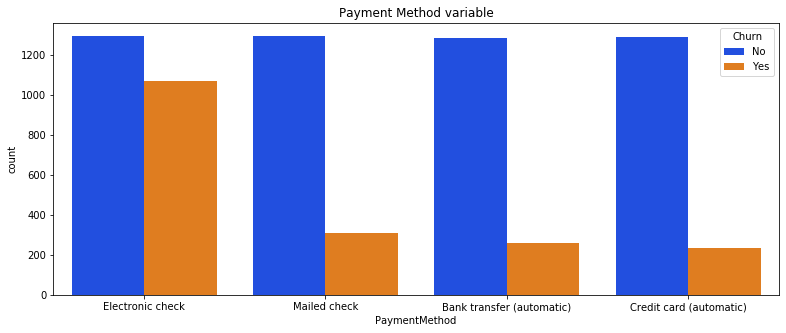

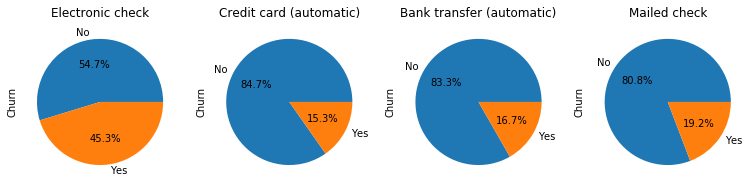

In [32]:
plt.figure(figsize = figsize)
g = sns.countplot(x=df.loc[:,"PaymentMethod"], hue=df["Churn"], palette = "bright")
plt.title("Payment Method variable")
plt.show()
classes = set(df["PaymentMethod"])
for cl_index, cl in enumerate(classes):
            
    plt.subplot(int(str(1)+str(len(classes))+str(cl_index+1))).set_title(cl)
            
    df.loc[df["PaymentMethod"]==cl]["Churn"].value_counts().plot.pie(figsize=figsize,autopct='%1.1f%%')

#### Notes:
> Very significant information is that the clients with electronic check as payment method has a huge tendency of churning (45%)

# Numeric variables

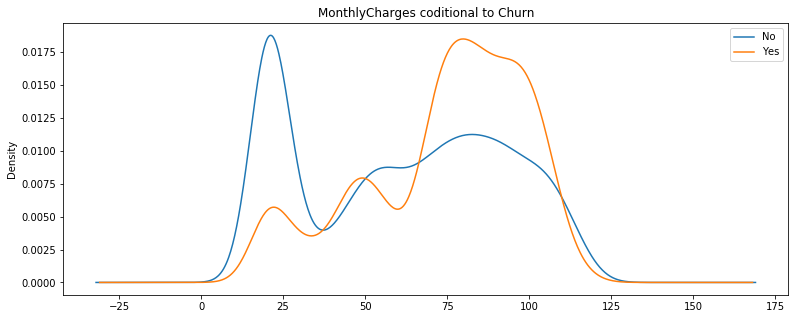

In [33]:
df.groupby('Churn')["MonthlyCharges"].plot.density(figsize=figsize)
plt.title('MonthlyCharges coditional to Churn')
plt.legend()
plt.show()
plt.show()

#### Notes:
>The two distributions of MonthlyCharges conditioned to the two classes of Churn are quite different. Customers who pays more monthly are more likely to churn while the opposite is true for customers who pay less. 

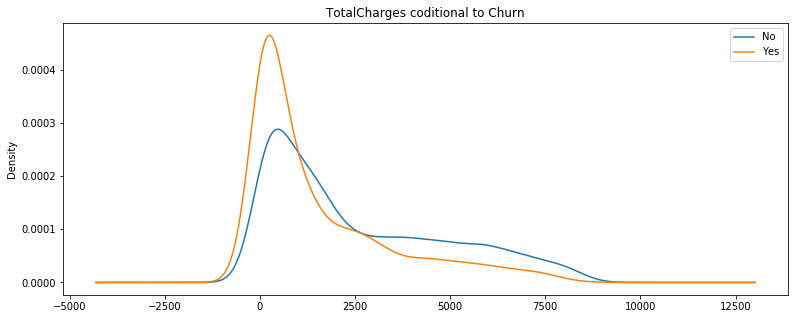

In [34]:
df.groupby('Churn')["TotalCharges"].plot.density(figsize=figsize)
plt.title('TotalCharges coditional to Churn')
plt.legend()
plt.show()

#### Notes:
>The two distributions of TotalCharges conditioned to the two classes of Churn are very similar. 

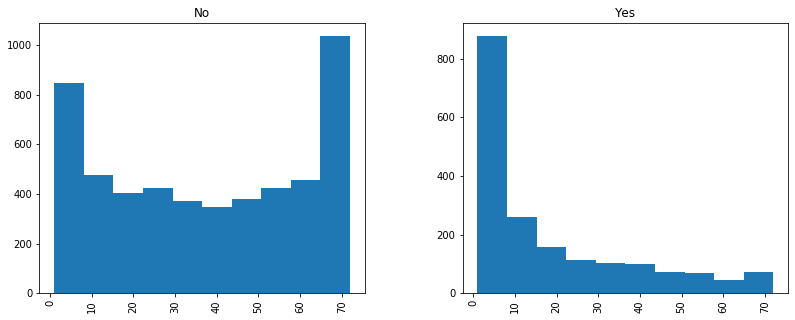

In [35]:
df["tenure"].hist(by=df["Churn"],figsize=figsize)
plt.show()

#### Notes:
>The two histograms of tenure conditioned to the two classes of Churn are different.
The tenure of customers who churns are more likely to be short: this means that lots of customers decides to churn fast.

<Figure size 1296x360 with 0 Axes>

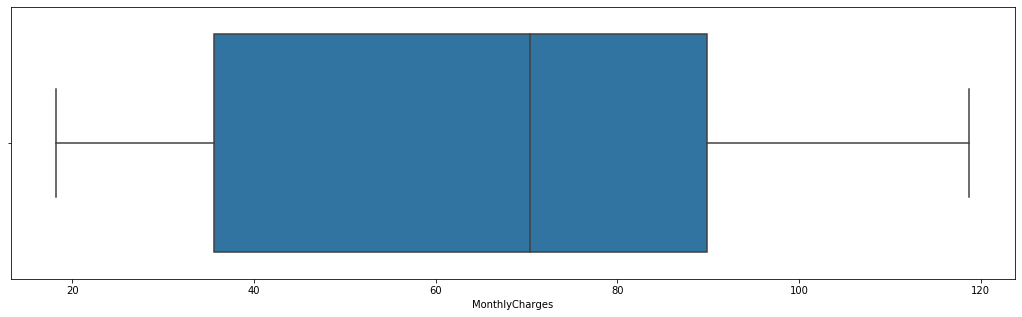

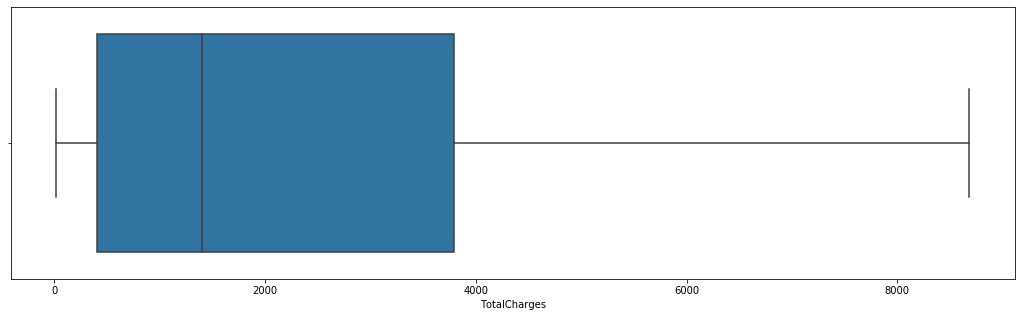

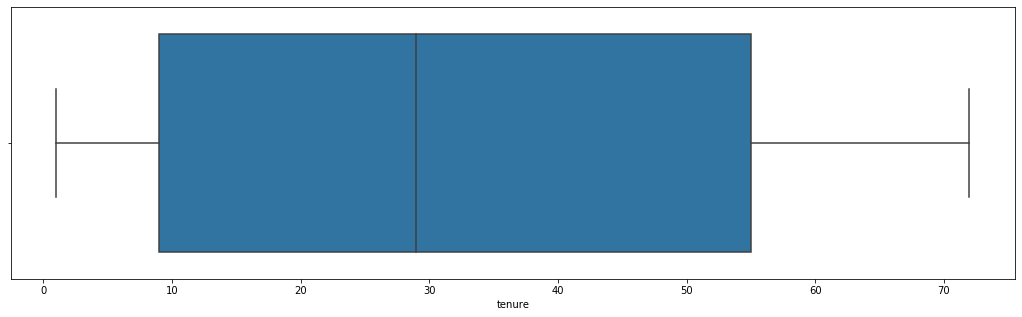

In [36]:
numerical_variables = [
"Churn",
"MonthlyCharges",
"TotalCharges",
"tenure"
]

for var in numerical_variables:
    plt.figure(figsize=(18,5))
    if var != "Churn":
        sns.boxplot(x=df[var])
        plt.show()

#### Notes:
>The numerical variables don't seems to have outliers.

# Feature Engineering

For convenience we assign value 0 for NO Churn, and 1 for YES Churn

In [37]:
df['Churn_yes_no'] = df['Churn']
df.loc[df.Churn=='No','Churn'] = 0 
df.loc[df.Churn=='Yes','Churn'] = 1

# Number of services:

A useful variable could be the total number of services that a client has. Let's create it!

In [38]:
df['Number_of_services'] = (df[['MultipleLines',
                                'OnlineSecurity', 
                                'DeviceProtection', 
                                'StreamingMovies', 
                                'TechSupport',
                                'StreamingTV', 
                                'OnlineBackup']] == 'Yes').sum(axis=1)

#### Proportion of Chun=Yes for each category

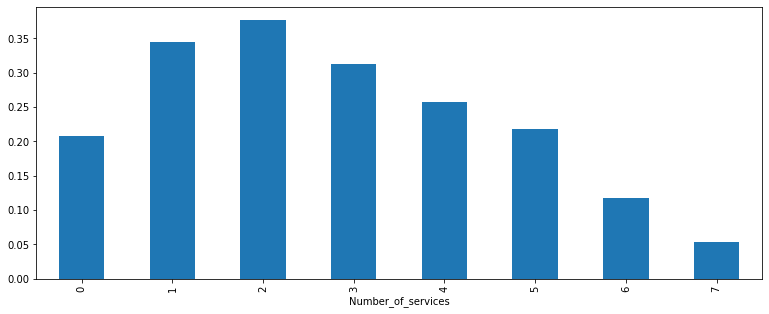

In [39]:
countbytarget, churnyes, count, proportion = Cat_vs_target(df, 'Churn', 1, 'customerID', 'Number_of_services', only_plot=False)

#### Proportion of Chun=No for each category

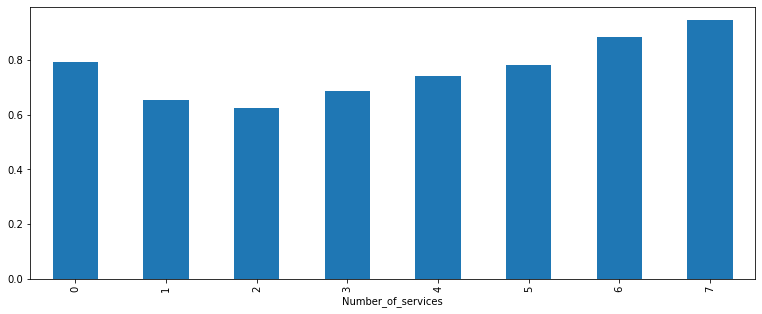

In [40]:
countbytarget, churnyes, count, proportion = Cat_vs_target(df, 'Churn', 0, 'customerID', 'Number_of_services', only_plot=False)

In [41]:
display(
countbytarget,
churnyes,
count,
proportion)

Customers
Number_of_services Churn           
0                  0           1317
                   1            346
1                  0            757
                   1            399
2                  0            596
                   1            361
3                  0            672
                   1            306
4                  0            691
                   1            240
5                  0            562
                   1            157
6                  0            371
                   1             49
7                  0            197
                   1             11

Churn: yes
Number_of_services            
0                         1317
1                          757
2                          596
3                          672
4                          691
5                          562
6                          371
7                          197

Customers
Number_of_services           
0                        1663
1                        1156
2                         957
3                         978
4                         931
5                         719
6                         420
7                         208

Churn proportion
Number_of_services                  
0                           0.791942
1                           0.654844
2                           0.622780
3                           0.687117
4                           0.742213
5                           0.781641
6                           0.883333
7                           0.947115

#### Notes:
> Customers with differetn number of services Churns with different probabilities. Customers with more services churn with lower probability.

# Tenure & Monthly Charge binned

We want to merge in classes MonthltyCharges and tenure. We will use k-means in order to group the more similar observations. 

We define the number of classes analyzing graphically the distribution of each variable.
We are using different methods: graphically analyzing the density of the variable and then we will verify the goodness of the division analyzing how the value of "intertia", derived from the fitting of the kmeans for every possible number of classes, changes (the so-called "elbow criterion").

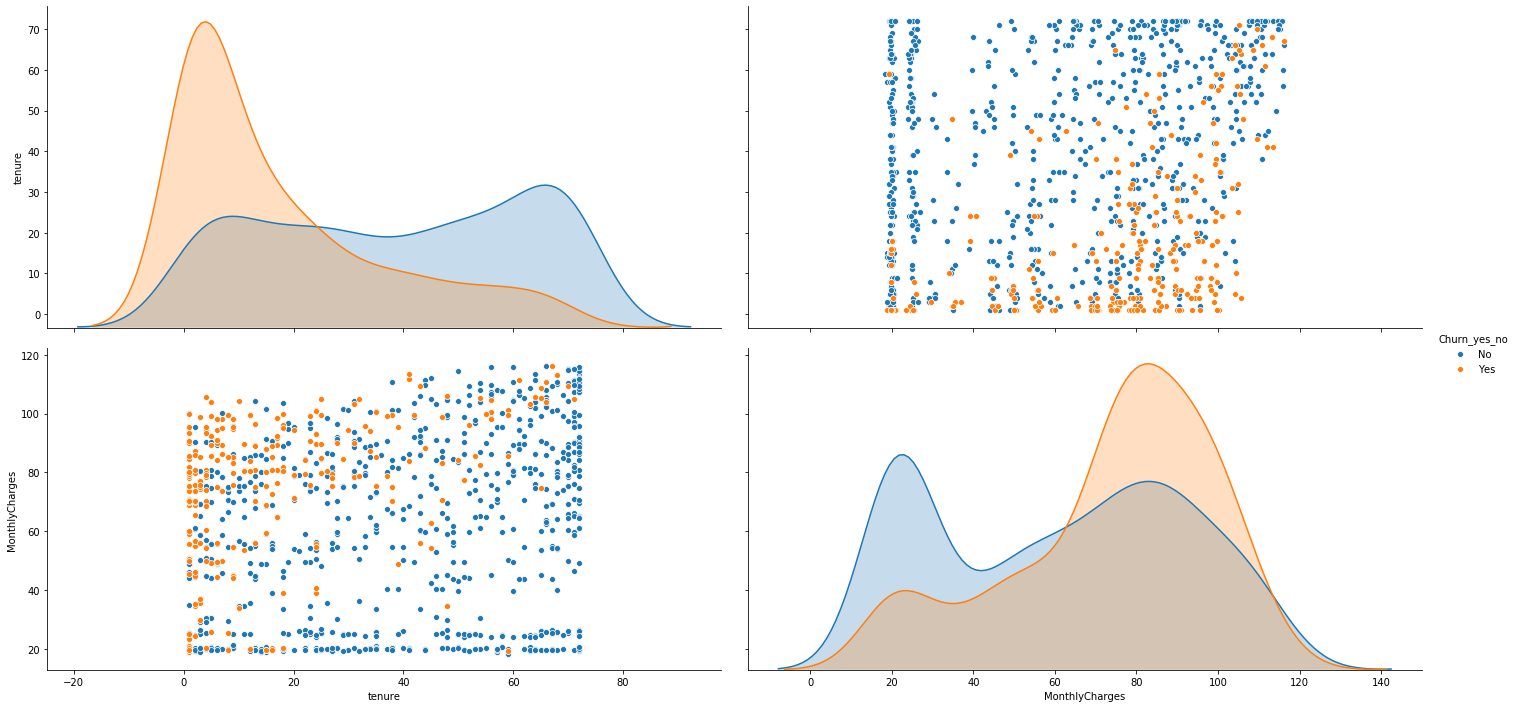

In [42]:
data=df[[
    'tenure',
    'MonthlyCharges',
    'Churn_yes_no'
]]

sns.pairplot(data.sample(n=1000), hue = 'Churn_yes_no', height=5,
            aspect=2)
plt.show()

#### Tenure binned in 3 classes:
If you have a quick look to the density of tenure in the pairplot, it is divided in two parts, but the two peaks are distant, so we put another class in between. In total we'll have three classes.

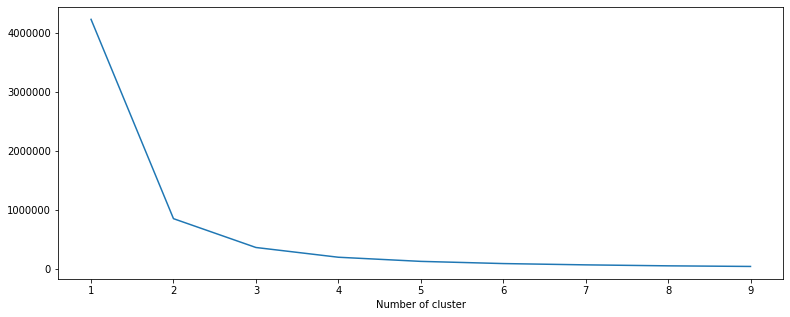

In [43]:
#Inertia of kmeans tenure
sse={}
data=df[['tenure']]

df_cluster = data.copy()

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000, random_state=r_seed).fit(df_cluster)
    df_cluster["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure(figsize=figsize)
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

#### Notes:
> The previous analisis is validated by elbow criterion. The curve flatten after 3 classes clusterization.

### Clustering of tenure

In [44]:
n_clusters=3
data=df[['tenure']]


kmeans = KMeans(n_clusters=n_clusters,random_state=r_seed)
kmeans.fit(data)
newvector_tenure = kmeans.predict(data)

#### MonthlyCharges in 4 classes:
Again, let's have a look at the pairplot: the density of Monthly Charges is mainly grouped in three parts. However the third part is pretty wide and we divide it in two. Moreover the Inertia's chart of Kmeans is less steep than the one of tenure between 3 and 4.

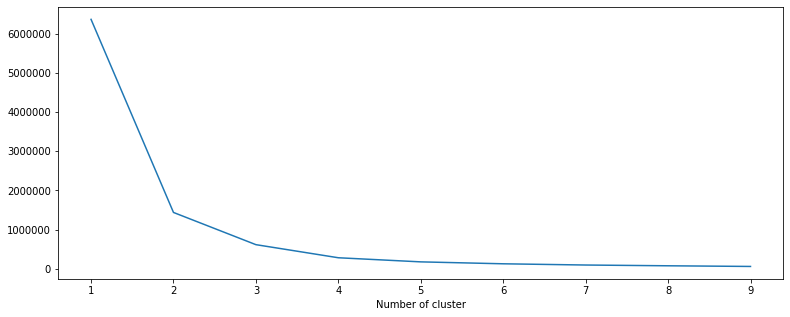

In [45]:
sse={}
data=df[['MonthlyCharges']]

df_cluster = data.copy()

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000, random_state=r_seed).fit(df_cluster)
    df_cluster["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure(figsize=figsize)
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

#### Notes:
> The previous analisis is validated by elbow criterion. The curve flatten after 4 classes clusterization.

### Clustering of MonthlyCharges

In [46]:
n_clusters=4
data=df[['MonthlyCharges']]


kmeans = KMeans(n_clusters=n_clusters,random_state=r_seed)
kmeans.fit(data)
newvector_MonthlyCharges = kmeans.predict(data)

In [47]:
df['tenure_binned']=newvector_tenure
df['MonthlyCharges_binned']=newvector_MonthlyCharges

### Churn=Yes rate for every tenure class:

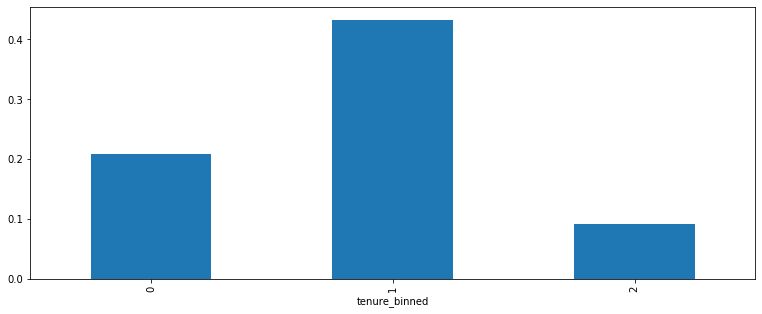

In [48]:
countbytarget, churnyes, count, proportion = Cat_vs_target(df, 'Churn', 1, 'customerID', 'tenure_binned', only_plot=False)

In [49]:
display(
countbytarget,
churnyes,
count,
proportion)

Customers
tenure_binned Churn           
0             0           1526
              1            403
1             0           1662
              1           1268
2             0           1975
              1            198

Churn: yes
tenure_binned            
0                     403
1                    1268
2                     198

Customers
tenure_binned           
0                   1929
1                   2930
2                   2173

Churn proportion
tenure_binned                  
0                      0.208917
1                      0.432765
2                      0.091118

#### Notes:
> The Churn rate is different for the 3 classes and the number of customers in each classes is uniformly distributed as can be seen in the tables (1929 for class 0; 2930 for class 1; 2173 for class 2).

### Churn rate for every Monthly Charge class:

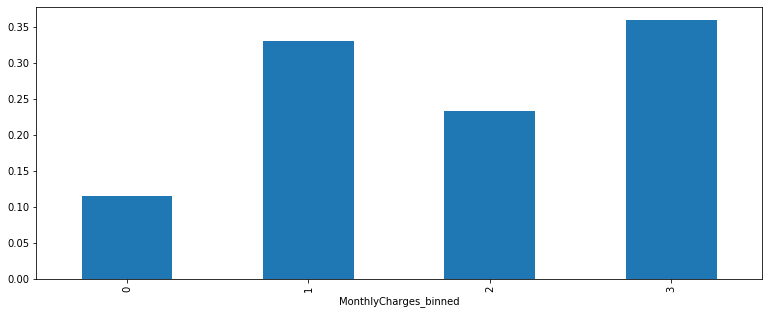

In [50]:
countbytarget, churnyes, count, proportion = Cat_vs_target(df, 'Churn', 1, 'customerID', 'MonthlyCharges_binned', only_plot=False)

In [51]:
display(
countbytarget,
churnyes,
count,
proportion)

Customers
MonthlyCharges_binned Churn           
0                     0           1583
                      1            205
1                     0           1292
                      1            638
2                     0           1006
                      1            305
3                     0           1282
                      1            721

Churn: yes
MonthlyCharges_binned            
0                             205
1                             638
2                             305
3                             721

Customers
MonthlyCharges_binned           
0                           1788
1                           1930
2                           1311
3                           2003

Churn proportion
MonthlyCharges_binned                  
0                              0.114653
1                              0.330570
2                              0.232647
3                              0.359960

#### Notes:
> The Churn rate is different for the 4 classes and the number of customers in each classes is uniformly distributed as can be seen in the tables (1300 for class 0; 1938 for class 1; 1788 for class 2; 2006 for class 3).


# Delta spend variable (dropped):

This variable is derived from the difference between average Monthly Charges (TotalCharges/Tenure) and Monthly Charges.

- If its value is negative it means that the client is _decreasing_ (on average he spent more thant how much he spends now).

- If its value is positive it means that the client is _increasing_ (on average he spent less than how much he spends now).

- If its value is equal it means that the client kept the expenditure constant. So the client is classfied as _equal_.


The interpretation of this variable is that we want to capture che engagement of each client. For example if he is increasing it could mean that he was glad about services, or that he wanted more services and so he is a demanding client.

In [52]:
df['avg_month_price'] =  round(df['TotalCharges']/df['tenure'],2)

def  delta_spend(df) :
    
    if df["MonthlyCharges"] == df['avg_month_price']:
        return "Equal"
    
    elif df["MonthlyCharges"] > df['avg_month_price']:
        return "Increasing"
    
    elif df["MonthlyCharges"] < df['avg_month_price']:
        return "Decreasing"
    
    
df["delta_spend"] = df.apply(lambda df:delta_spend(df),
                                      axis = 1)

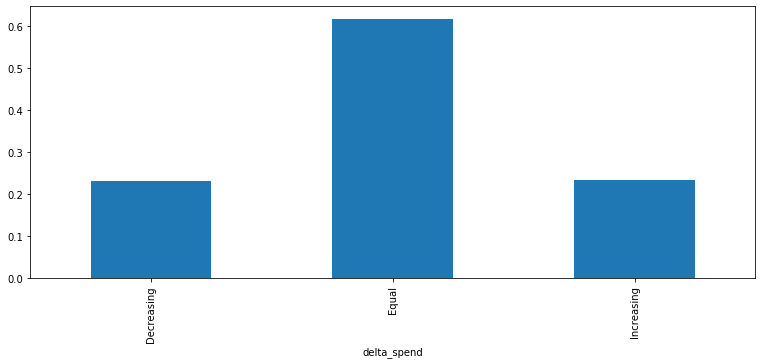

In [53]:
countbytarget, churnyes, count, proportion = Cat_vs_target(df, 'Churn', 1, 'customerID', 'delta_spend', only_plot=False)

In [54]:
display(
countbytarget,
churnyes,
count,
proportion)

Customers
delta_spend Churn           
Decreasing  0           2464
            1            737
Equal       0            239
            1            383
Increasing  0           2460
            1            749

Churn: yes
delta_spend            
Decreasing          737
Equal               383
Increasing          749

Customers
delta_spend           
Decreasing        3201
Equal              622
Increasing        3209

Churn proportion
delta_spend                  
Decreasing           0.230241
Equal                0.615756
Increasing           0.233406

#### Notes:
> The Churn rate is different for the 3 classes.
But the number of customers in each classes is not uniformly distributed as can be seen in the tables (3201 for class Decreasing; 622 for class Equal; 3209 for class Increasing).



##### Furthermore this variable have three probelms:

- Customers have different tenure. Lots of customers could be classified as equal only because they didn't have time to change contract.

- We could use a range to determine when the client has constant expenditure, but this adds a difficult to justify degree of freedom.

- We don't know exactly what's inside Total Charges: is it only the sum of the Monthly Charge or also other types of costs, such as administrative or exceptional costs?

## So we decide to drop this variable  and we created its numerical version (see below)

# expVSreal:

This variable is derived from the difference between average Monthly Charges (TotalCharges/Tenure) and Monthly Charges.

In [55]:
df['avg_month_price'] =  round(df['TotalCharges']/df['tenure'],2)
df['expVSreal']= df['MonthlyCharges'] - df['avg_month_price']

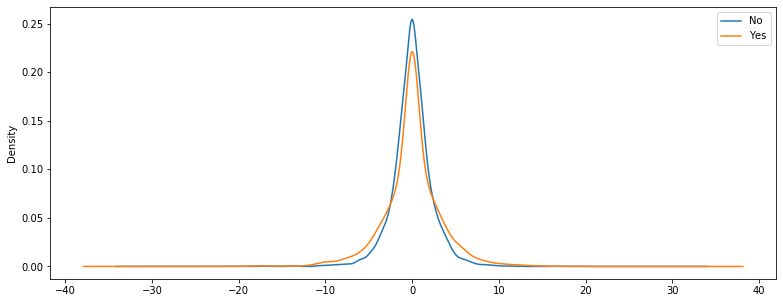

In [56]:
df.groupby('Churn_yes_no')['expVSreal'].plot.density(figsize=figsize)
plt.legend()
plt.show()

#### Notes:
> The variance of the two distribution is slightly different between those who churn and those who don't.

In [57]:
df.drop("delta_spend", axis=1, inplace=True)

In [58]:
df.drop("avg_month_price", axis=1, inplace=True)

In [59]:
print(*df.columns, sep='\n')

customerID
gender
SeniorCitizen
Partner
Dependents
tenure
PhoneService
MultipleLines
InternetService
OnlineSecurity
OnlineBackup
DeviceProtection
TechSupport
StreamingTV
StreamingMovies
Contract
PaperlessBilling
PaymentMethod
MonthlyCharges
TotalCharges
Churn
Churn_yes_no
Number_of_services
tenure_binned
MonthlyCharges_binned
expVSreal


# Some more EDA regarding variables created:

Here we wanted to visualize the relations between Monthly Charges, Total Charges, tenure (numerical) and categorical variables. This is achieved by 3d scatterplots. The classes are coded using different colors.

In [60]:
scatterplot3d(
    df,
    x='MonthlyCharges',
    y='TotalCharges',
    z='tenure',
    color='Churn_yes_no')

#### Notes:
> The two target classes are very merged in these 3 dimensions, but customers who churns seems to be grouped together. Let's try to find some variables that subset sthe space in the right way.

In [61]:
scatterplot3d(df,
              x='MonthlyCharges',
              y='TotalCharges',
              z='tenure',
              color='Contract'
)

#### Notes:
>Customers with Month-to-Month contracts are distributed similarly to those that churn in this 3 dimensional space. It seems that this variable could be very promising for the classification of churn. The reason could be related to the fact that people with Month-to-Month contracts are less engaged that those who have different types of contract.

In [62]:
variables = [
'tenure_binned',
'MonthlyCharges_binned'
]
for var in variables:
    
    scatterplot3d(
    df,
    x='MonthlyCharges',
    y='TotalCharges',
    z='tenure',
    color=var)

#### Notes:
>This two subsetting of the space togheter with the subsetting done by the contract type could be usefull to identify vertically and orizontally the space in the right way.

In [63]:
print(*df.columns, sep='\n')

customerID
gender
SeniorCitizen
Partner
Dependents
tenure
PhoneService
MultipleLines
InternetService
OnlineSecurity
OnlineBackup
DeviceProtection
TechSupport
StreamingTV
StreamingMovies
Contract
PaperlessBilling
PaymentMethod
MonthlyCharges
TotalCharges
Churn
Churn_yes_no
Number_of_services
tenure_binned
MonthlyCharges_binned
expVSreal


In [ ]:
#QUI SI SEPARANO I DUE NOTEBOOK UNITI

# Train and test split

Here we perform the splitting in train and test. In order to keep the same ratio between Churn=Yes and Churn=No we perfromed the Stratified Shuffle Split. The splitting is done keeping 80% of the data as train an the rest as test.

In [64]:
df.drop(['customerID','Churn_yes_no'], axis = 1, inplace = True)

In [65]:
df["SeniorCitizen"] = df["SeniorCitizen"].replace({1:"Yes",0:"No"})
df.SeniorCitizen

0        No
1        No
2        No
3        No
4        No
       ... 
7027     No
7028     No
7029     No
7030    Yes
7031     No
Name: SeniorCitizen, Length: 7032, dtype: object

In [66]:
my_split = StratifiedShuffleSplit(test_size=0.20, n_splits=1, random_state=1234)

# Verifying Same proportion and splitting
for train_index, test_index in my_split.split(df, df['Churn']):
    print(len(train_index), len(test_index))
    print((df.loc[train_index, 'Churn'].value_counts())/len(df.loc[train_index]), (df.loc[test_index, 'Churn'].value_counts())/len(df.loc[test_index]))
    train = df.loc[train_index]
    test = df.loc[test_index]

5625 1407
0    0.734222
1    0.265778
Name: Churn, dtype: float64 0    0.734186
1    0.265814
Name: Churn, dtype: float64


---
---

# Encoding

We decided to try two kind of approaches to encode the categorical variables:
- One-hot Encoding (train1 and test1)
- Mean encoding with smoothing (train2 and test2)
> Note: The mean encoding have benefits but also drawbacks: the overfitting. To solve theis issue we used the mean ecoding with smoothing parameter ('m' in the function 'mean_encoding' function) set to 10.

In [67]:
train1 = train.copy() 
test1 = test.copy()

In [68]:
columns1 = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'tenure_binned', 'MonthlyCharges_binned']
for i in columns1:
    train1[i] = train1[i].astype('category')
    test1[i] = test1[i].astype('category')

In [69]:
train1 = pd.get_dummies(train1)
test1 = pd.get_dummies(test1)

---

In [70]:
train2 = train.copy()
test2 = test.copy()

In [71]:
encoding_dicts = {}
for c in ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod','tenure_binned','MonthlyCharges_binned']:
    train2[c], d = mean_encoding(train2, c, 'Churn', smooth=True, m=10)
    encoding_dicts[c] = d

In [72]:
m = train2['Churn'].mean()
for i in encoding_dicts:
     test2[i] = test[i].apply(lambda x: encoding_dicts[i][x] if x in encoding_dicts[i] else m)

---
---

# Feature Selection: correlation matrices

The selection of the features is done by removing the highly correlated features. Among those correlated we choose the one more correlated with the target.

### Correlation matrix with one hot encoding (all variables)

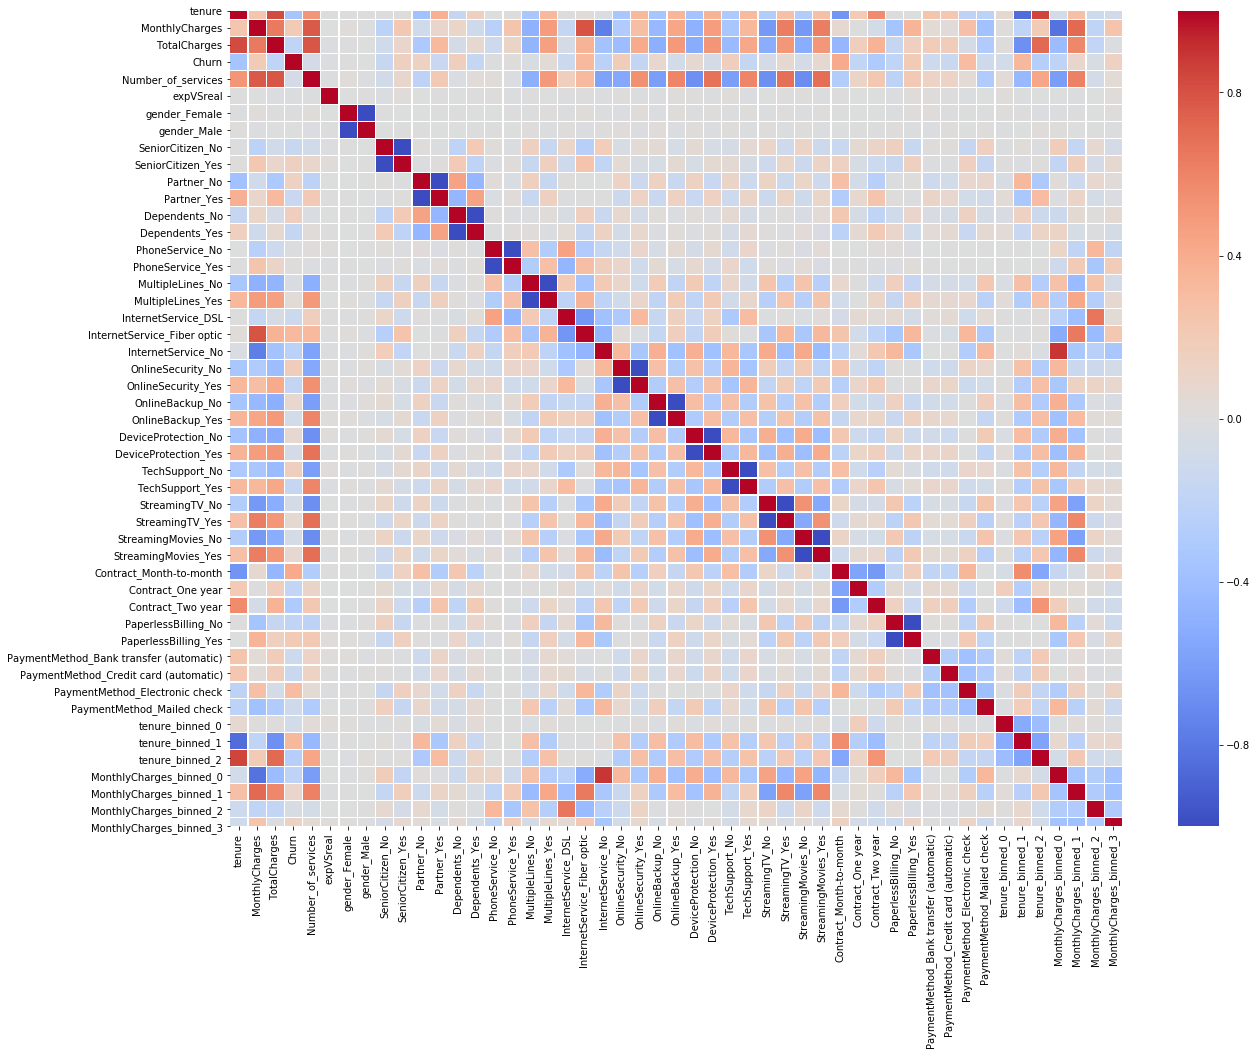

In [73]:
df_dropped, dropped = Correlations(train1,'Churn')

In [74]:
dropped

['gender_Male',
 'SeniorCitizen_No',
 'Partner_Yes',
 'Dependents_Yes',
 'PhoneService_Yes',
 'MultipleLines_No',
 'OnlineSecurity_Yes',
 'OnlineBackup_Yes',
 'DeviceProtection_No',
 'TechSupport_Yes',
 'StreamingTV_Yes',
 'StreamingMovies_Yes',
 'PaperlessBilling_No']

In [75]:
train1.drop(dropped, axis = 1, inplace = True)
test1.drop(dropped,axis =1, inplace = True)

## Correlation matrix mean encoding

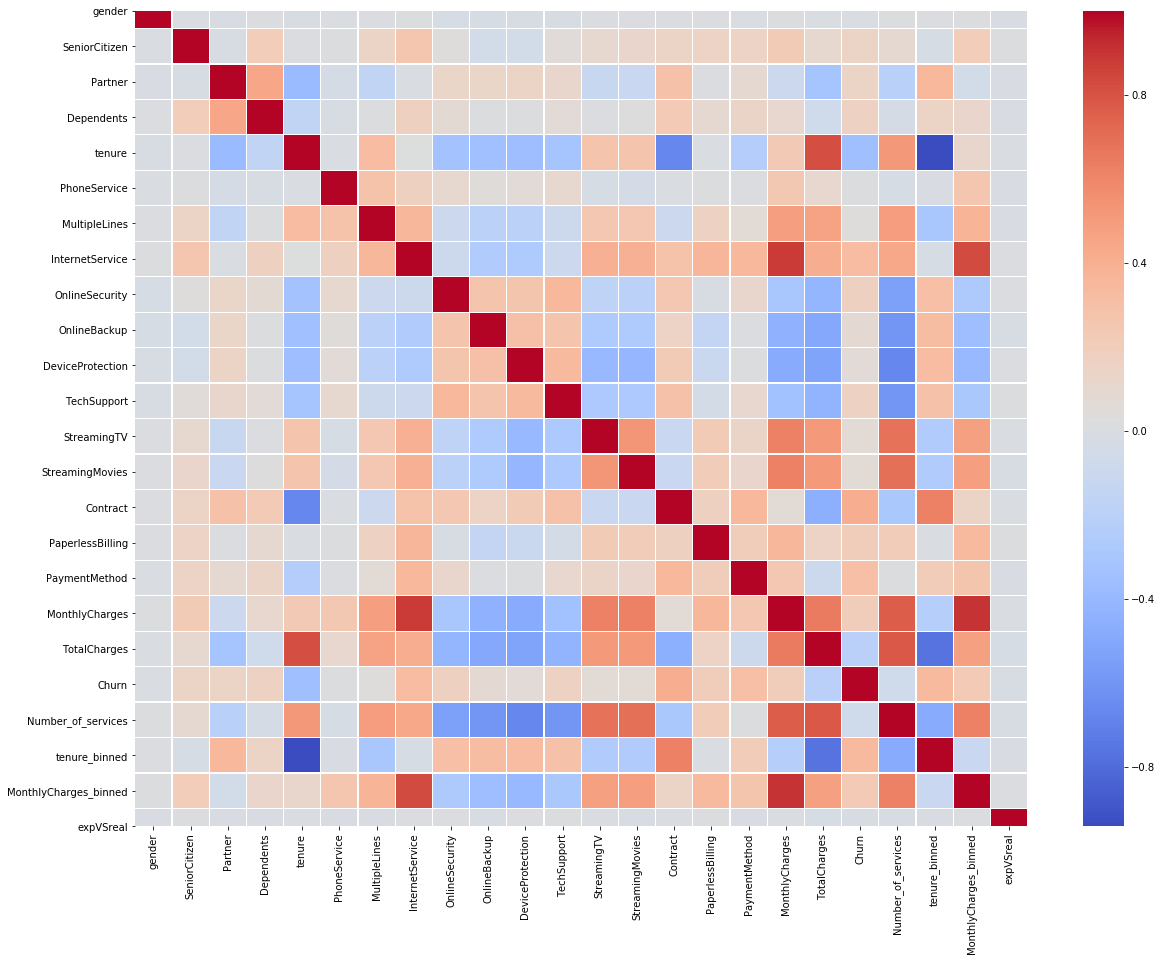

In [76]:
df_dropped, dropped = Correlations(train2,'Churn')

In [77]:
dropped

['tenure_binned', 'MonthlyCharges']

In [78]:
train2.drop(dropped, axis = 1, inplace = True)

In [79]:
test2.drop(dropped, axis = 1, inplace = True)

In [80]:
def results(cv):
    parameters = cv.cv_results_['params']
    table = pd.DataFrame.from_dict(parameters)
    table['mean_train_score'] = cv.cv_results_['mean_train_score']
    table['mean_test_score'] = cv.cv_results_['mean_test_score']
    
    return table

In [81]:
def metrics_ROC(model, X_test, modelname, y_test, y_prob):
    fpr, tpr, th = roc_curve(y_test, y_prob)
    
    plt.figure(1, figsize=(10, 7))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    
    plt.title(f'{modelname} - ROC curve - test')
    
    plt.show()
    
    th1 = np.arange(0.1,0.6,0.05)
    f1={}
    for th in th1:
        y_pred = [1 if i >= th else 0 for i in y_prob]
        f1[th] = (f1_score(y_test, y_pred))
    
    
    optimal_threshold = max(f1, key=f1.get)
    
    y_pred = [1 if i >=optimal_threshold  else 0 for i in model.predict_proba(X_test)[:,1]]
    conf_matrix = pd.DataFrame(
        metrics.confusion_matrix(y_test, y_pred),
        columns=pd.MultiIndex(levels=[['Predicted'], 
                                      ['0', '1']], 
                              codes=[[0, 0], 
                                     [0, 1]]),
        index=pd.MultiIndex(levels=[['Actual'], 
                                    ['0', '1']], 
                            codes=[[0, 0], 
                                   [0, 1]]))
    
    auc=roc_auc_score(y_test, y_prob)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    scores = {modelname: {'AUC':auc,
                         'Precision':precision,
                         'Recall':recall,
                          'Accuracy':accuracy,
                          'f1':f1
                         
                         }}
    scores = pd.DataFrame(scores).T
    
    print('AUC score: ',auc)
    print('Precision: ',precision)
    print('Recall: ',recall)
    print('Accuracy: ',accuracy)
    print('F1 score: ',f1)
    print('Optimal threshold: ', optimal_threshold)
    print('\n')
    print('Confusion Matrix:')
    display(conf_matrix)
    print('\n')
    print('Classification report:\n\n', metrics.classification_report(y_test, y_pred))
    
    return scores

# Splitting features and target (test)

In [82]:
X_test_onehot = test1.drop(['Churn'], axis = 1)
Y_test_onehot = test1['Churn']
X_test_mean = test2.drop(['Churn'], axis = 1)
Y_test_mean = test2['Churn']

# Upsampling

As seen in the previous plots our data is very umbalanced. To solve this problem and increase the performances of the models we decided to use upsampling. The algorithm resample randomly from the minority class in order to rebalance the data. This should allow in the fitting process the model to learn from both classes.

### train1 upsampling (one hot encoding)

In [83]:
df_majority = train1[train1.Churn==0]
df_minority = train1[train1.Churn==1]

df_minority_upsampled = resample(df_minority, 
                                 replace=True,
                                 n_samples=len(df_majority),
                                 random_state=123)

train_onehot_upsampled = pd.concat([df_majority, df_minority_upsampled])

In [84]:
X_train_onehot = train_onehot_upsampled.drop(['Churn'], axis = 1)
Y_train_onehot = train_onehot_upsampled['Churn']

### train2 upsampling (mean encoding)

In [85]:
df_majority = train2[train2.Churn==0]
df_minority = train2[train2.Churn==1]

df_minority_upsampled = resample(df_minority, 
                                 replace=True,   
                                 n_samples=len(df_majority),
                                 random_state=123)

train_mean_upsampled = pd.concat([df_majority, df_minority_upsampled])

In [86]:
X_train_mean = train_mean_upsampled.drop(['Churn'], axis = 1)
Y_train_mean = train_mean_upsampled['Churn']

---
---

# Models 

The models that we tried are the following:
- Support Vector Classifier
- Logistic Regression
- Gradient Boosting
- Random Forest
- XGBoost

For each of them we fitted two versions, one with data encoded using One-hot Encoding and one using mean encoding. 
We performed a grid search to fine tune their hyperparameters maximising the Roc AUC. We decided to maximise this metric in order to fine tune also the threshold used for the hard classification. In this particular fine tuning we maximised the F1 score. This metric is been selected because even if our main objective is to reach the highest recall possible due to the nature of our problem (spotting Churn clients is more relevant that spotting non churning clients) we wanted also to reach an acceptable level of precision. Then the best model is been used as input of a the Lime algorithm (see below) in order to be able to interpret the results of black box models to help the decision making process.

Every model is been trained with upsampled data except the XGBoost. The reason behind this choice is that by setting a specifc parameter related to the umbalanceness problem we reached highest performances in terms of F1. The grid search of the XGBoost is been done in another notebook due to the computational and time complexity.

In [87]:
cv=5
n_jobs=-1
verbose=4
scoring='roc_auc'

# Support vector classifier

In [88]:
classifier = SVC(gamma='scale', probability=True)

pipeline = Pipeline([
    
    ('scaler', MinMaxScaler(feature_range=(-1,1))), 
    ('model', classifier)
    
])
            
grid={
    "model__C": [100,1000, 10],
    "model__kernel": ['sigmoid', 'rbf'],
    
}

### One-hot encoding

In [89]:
X = X_train_onehot
y = Y_train_onehot
X_test = X_test_onehot
y_test = Y_test_onehot

In [ ]:
CV = GridSearchCV(pipeline, 
                  grid, 
                  scoring = 'roc_auc', 
                  n_jobs= n_jobs, 
                  cv = cv, 
                  verbose = verbose,
                  return_train_score=True)

CV.fit(X,y)
results(CV)

In [ ]:
model = CV.best_estimator_
model.fit(X,y)

In [ ]:
y_prob = [y for x,y in model.predict_proba(X_test)]

In [ ]:
SVC_onehot = metrics_ROC(model, X_test, 'SVC - One Hot Encoding',  y_test, y_prob)

### Mean encoding

In [ ]:
X = X_train_mean
y = Y_train_mean

X_test = X_test_mean
y_test = Y_test_mean

In [ ]:
CV = GridSearchCV(pipeline, 
                  grid, 
                  scoring = 'roc_auc', 
                  n_jobs= n_jobs, 
                  cv = cv, 
                  verbose = verbose,
                  return_train_score=True)

CV.fit(X,y)
results(CV)

In [ ]:
model = CV.best_estimator_
model.fit(X,y)

In [ ]:
y_prob = [y for x,y in model.predict_proba(X_test)]

In [ ]:
SVC_mean = metrics_ROC(model, X_test, 'SVC - Mean Encoding',  y_test, y_prob)

---
---

# Logistic Regression
###  Grid search for parameter tuning (l2 penalty)

In [90]:
classifier = LogisticRegression(max_iter = 500,
                               penalty='l2')

pipeline = Pipeline([
    
    ('scaler', MinMaxScaler(feature_range=(-1,1))), 
    ('model', classifier)
    
])
            
grid = {
    "model__C": np.logspace(-3,3,7), 
    "model__solver": ['newton-cg','lbfgs', 'sag', 'saga']
}


### One-hot encoding

In [91]:
X = X_train_onehot
y = Y_train_onehot
X_test = X_test_onehot
y_test = Y_test_onehot

In [92]:
CV = GridSearchCV(pipeline, 
                  grid, 
                  scoring = scoring, 
                  n_jobs= n_jobs, 
                  cv = cv, 
                  verbose = verbose,
                  return_train_score=True)

CV.fit(X,y)
results(CV)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:   26.6s finished


model__C model__solver  mean_train_score  mean_test_score
0      0.001     newton-cg          0.848466         0.846819
1      0.001         lbfgs          0.848466         0.846821
2      0.001           sag          0.848466         0.846820
3      0.001          saga          0.848466         0.846820
4      0.010     newton-cg          0.851784         0.849271
5      0.010         lbfgs          0.851785         0.849269
6      0.010           sag          0.851783         0.849270
7      0.010          saga          0.851785         0.849271
8      0.100     newton-cg          0.854460         0.851476
9      0.100         lbfgs          0.854460         0.851468
10     0.100           sag          0.854460         0.851473
11     0.100          saga          0.854461         0.851477
12     1.000     newton-cg          0.855525         0.852378
13     1.000         lbfgs          0.855525         0.852376
14     1.000           sag          0.855526         0.852378
15     1.000          saga          0.855525         0.852375
16    10.000     newton-cg          0.855708         0.852493
17    10.000         lbfgs          0.855707         0.852495
18    10.000           sag          0.855707         0.852492
19    10.000          saga          0.855707         0.852488
20   100.000     newton-cg          0.855721         0.852489
21   100.000         lbfgs          0.855721         0.852491
22   100.000           sag          0.855722         0.852493
23   100.000          saga          0.855723         0.852486
24  1000.000     newton-cg          0.855717         0.852486
25  1000.000         lbfgs          0.855718         0.852489
26  1000.000           sag          0.855716         0.852489
27  1000.000          saga          0.855718         0.852486

In [93]:
model = CV.best_estimator_
model.fit(X,y)

Pipeline(memory=None,
         steps=[('scaler', MinMaxScaler(copy=True, feature_range=(-1, 1))),
                ('model',
                 LogisticRegression(C=10.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=500,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [94]:
y_prob = [y for x,y in model.predict_proba(X_test)]

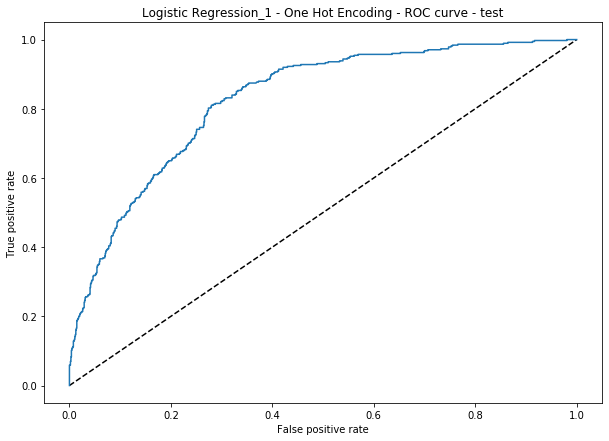

AUC score:  0.8262847425338171
Precision:  0.5008210180623974
Recall:  0.8155080213903744
Accuracy:  0.7348969438521677
F1 score:  0.6205493387589014
Optimal threshold:  0.45000000000000007


Confusion Matrix:


Predicted     
                 0    1
Actual 0       729  304
       1        69  305



Classification report:

               precision    recall  f1-score   support

           0       0.91      0.71      0.80      1033
           1       0.50      0.82      0.62       374

    accuracy                           0.73      1407
   macro avg       0.71      0.76      0.71      1407
weighted avg       0.80      0.73      0.75      1407



In [95]:
LogReg1_onehot = metrics_ROC(model, X_test, 'Logistic Regression_1 - One Hot Encoding',  y_test, y_prob)

### Mean encoding

In [ ]:
X = X_train_mean
y = Y_train_mean

X_test = X_test_mean
y_test = Y_test_mean

In [ ]:
CV = GridSearchCV(pipeline, 
                  grid, 
                  scoring = scoring, 
                  n_jobs= n_jobs, 
                  cv = cv, 
                  verbose = verbose,
                  return_train_score=True)

CV.fit(X,y)
results(CV)

In [ ]:
model = CV.best_estimator_
model.fit(X,y)

In [ ]:
y_prob = [y for x,y in model.predict_proba(X_test)]

In [ ]:
LogReg1_mean = metrics_ROC(model, X_test, 'Logistic Regression_1 - Mean Encoding',  y_test, y_prob)

---
---

# Logistic Regression
### Different solver and penalization (each solver accept only a specific kind of regularization)

In [ ]:
classifier = LogisticRegression(max_iter = 500)

pipeline = Pipeline([
    
    ('scaler', MinMaxScaler(feature_range=(-1,1))), 
    ('model', classifier)
    
])

grid = {
    "model__C": np.logspace(-3,3,7), 
    "model__penalty": ["l1"], 
    "model__solver": ['liblinear', 'saga']
}


### One-hot encoding

In [ ]:
X = X_train_onehot
y = Y_train_onehot
X_test = X_test_onehot
y_test = Y_test_onehot

In [ ]:
CV = GridSearchCV(pipeline, 
                  grid, 
                  scoring = scoring, 
                  n_jobs= n_jobs, 
                  cv = cv, 
                  verbose = verbose,
                  return_train_score=True)

CV.fit(X,y)
results(CV)

In [ ]:
model = CV.best_estimator_
model.fit(X,y)

In [ ]:
y_prob = [y for x,y in model.predict_proba(X_test)]

In [ ]:
LogReg2_onehot = metrics_ROC(model, X_test, 'Logistic Regression_2 - One Hot Encoding',  y_test, y_prob)

### Mean encoding

In [ ]:
X = X_train_mean
y = Y_train_mean

X_test = X_test_mean
y_test = Y_test_mean

In [ ]:
CV = GridSearchCV(pipeline, 
                  grid, 
                  scoring = scoring, 
                  n_jobs= n_jobs, 
                  cv = cv, 
                  verbose = verbose,
                  return_train_score=True)

CV.fit(X,y)
results(CV)

In [ ]:
model = CV.best_estimator_
model.fit(X,y)

In [ ]:
y_prob = [y for x,y in model.predict_proba(X_test)]

In [ ]:
LogReg2_mean = metrics_ROC(model, X_test, 'Logistic Regression_2 - Mean Encoding',  y_test, y_prob)

---
---

# Gradient Boosting

In [ ]:
classifier = GradientBoostingClassifier(random_state = 1234)

pipeline = Pipeline([
    
    ('scaler', MinMaxScaler(feature_range=(-1,1))), 
    ('model', classifier)
    
])


### One-hot encoding

In [ ]:
X = X_train_onehot
y = Y_train_onehot
X_test = X_test_onehot
y_test = Y_test_onehot

In [ ]:
grid = {'model__loss' :['deviance', 'exponential'],
          'model__learning_rate' : [0.001,0.0001,0.01],
          'model__subsample' : np.logspace(0, -3, 3),
          'model__max_features': ['sqrt','log2', 0.2, 0.5,0.8,1],
          'model__min_samples_split' : np.logspace(-1, -3, 3),
          'model__n_estimators':(300,500,100)
}

In [ ]:
CV = GridSearchCV(pipeline, 
                  grid, 
                  scoring = scoring, 
                  n_jobs= n_jobs, 
                  cv = cv, 
                  verbose = verbose,
                  return_train_score=True)
CV.fit(X,y)  

In [ ]:
CV.best_params_

In [ ]:
model = CV.best_estimator_
model.fit(X,y)

In [ ]:
y_prob = [y for x,y in model.predict_proba(X_test)]

In [ ]:
GradBoost_onehot = metrics_ROC(model, X_test, 'Gradient Boosting - One Hot Encoding',  y_test, y_prob)

### Mean encoding

In [ ]:
X = X_train_mean
y = Y_train_mean

X_test = X_test_mean
y_test = Y_test_mean

In [ ]:
CV = GridSearchCV(pipeline, 
                  grid, 
                  scoring = scoring, 
                  n_jobs= n_jobs, 
                  cv = cv, 
                  verbose = verbose,
                  return_train_score=True)
CV.fit(X,y)  

In [ ]:
CV.best_params_

In [ ]:
model = CV.best_estimator_
model.fit(X,y)

In [ ]:
y_prob = [y for x,y in model.predict_proba(X_test)]

In [ ]:
GradBoost_mean = metrics_ROC(model, X_test, 'Gradient Boosting - Mean Encoding',  y_test, y_prob)

---
---

# Random Forest

In [ ]:
classifier = RandomForestClassifier()

pipeline = Pipeline([
    
    ('scaler', MinMaxScaler(feature_range=(-1,1))), 
    ('model', classifier)
    
])


grid = {
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [2, 3, 4, 5],
    'model__n_estimators': [100,200,300,400,500],
    'model__min_samples_leaf': [0.1, 0.01, 0.001]
         }


### One-hot encoding

In [ ]:
X = X_train_onehot
y = Y_train_onehot
X_test = X_test_onehot
y_test = Y_test_onehot

In [ ]:
CV = GridSearchCV(pipeline, 
                  grid, 
                  scoring = scoring, 
                  n_jobs= n_jobs, 
                  cv = cv, 
                  verbose = verbose,
                  return_train_score=True)

CV.fit(X,y)
results(CV)

In [ ]:
model = CV.best_estimator_
model.fit(X,y)

In [ ]:
y_prob = [y for x,y in model.predict_proba(X_test)]

In [ ]:
RandomForest_onehot = metrics_ROC(model, X_test, 'Random Forest - One Hot Encoding',  y_test, y_prob)

### Mean encoding

In [ ]:
X = X_train_mean
y = Y_train_mean

X_test = X_test_mean
y_test = Y_test_mean

In [ ]:
CV = GridSearchCV(pipeline, 
                  grid, 
                  scoring = scoring, 
                  n_jobs= n_jobs, 
                  cv = cv, 
                  verbose = verbose,
                  return_train_score=True)

CV.fit(X,y)
results(CV)

In [ ]:
model = CV.best_estimator_
model.fit(X,y)

In [ ]:
y_prob = [y for x,y in model.predict_proba(X_test)]

In [ ]:
RandomForest_mean = metrics_ROC(model, X_test, 'Random Forest - Mean Encoding',  y_test, y_prob)

---
---

# XGboost (No upsampling)

# XBGOOST classifier  

> XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way. The same code runs on major distributed environment (Hadoop, SGE, MPI) and can solve problems beyond billions of examples.

## 3 subclasses  of parameters to get through:

- *General Parameters*: Guide the overall functioning `G`
- *Booster Parameters*: Guide the individual booster (tree/regression) at each step `B`
- *Learning Task Parameters*: Guide the optimization performed `L`

-------

## "Cross Validated"  approach:

Due to the big amount of parameters to search for we tried a side approach that will help us making the best choices in setting the parameters.
1. We tryed to enclose a grid of values one important parameter at a time given our dataset. This procedure was made by looking are the neg_log_loss and the selection of the candidates was made by elbow-method. 

2. These values selected were stored and then used in a Randomized Grid Search along with the less relevant parameters whose grid of values are wider. 

3. Present Results:
    1. through Feature Importance
    2. Accuracy
    3. AUC
    4. F1
    5. confusion matrix
    6. ROC curve 
    7. classification report
    
4. select the best model and make it perform 

5. evaluate the model performance and classfication and plot the final tree

## Important Paramteres inspected

- *n_estimators*  number of boosted trees to fit. To a point, more are better but will take more time.
- *max_depth* Maximum tree depth for base learners. Used to control overfitting.
- *learning_rate* learning rate is commonly set = 0.3 but in this case could be smaller due to the shape of the dataset
- *min_child_weight* Minimum sum of instance weight (hessian) needed in a child. Used to control over-fitting. Values that are too high can lead to under-fitting. If the classes are highly unbalanced, lower values (even 1) can be alright.
- *scale_pos_weight* Control the balance of positive and negative weights, useful for unbalanced classes, that is why upsampling is not used in this model. The unbalance issue can be sized by setting the parameter, as documentiation suggests equal to the ratio of negative values (majority) over the positive value (minority)

` contatore = Counter(train1_y)
stima = contatore[0] / contatore[1]` 

------

# Find a Right span  of VALUES OF n_estimators


### n_estimators:   


- for low medium dataset documentation suggest 1000 but at the same time it doesn not provide any reference to understand what is medium and what is low, so apparently we would say that it is purely low: I still perform a grid search in order to reduce the dimensionality of the parameter set 
- The total number of iterations is 200, composed by 20 times that 50 is in 1000 and then multiplied by 10, that comes from the 10 fold 
- The plot is helping us through the elbow criterion to fix the right number of trees: the output suggests 50, however the first derivative appears pretty similar one to each other, in the second part of the curve the log loss is flatter so we can discard them. so 50, 100, 150, 200, 250 are some reasonable choices 

[REF](https://books.google.it/books?id=HgmqDwAAQBAJ&pg=PA83&lpg=PA83&dq=plt.errorbar(n_estimators,+means,+yerr%3Dstds)&source=bl&ots=nLlFc4JbIz&sig=ACfU3U3CRHyOO4oGUhYvTpuNHKW48_Pcbw&hl=it&sa=X&ved=2ahUKEwiV1r6EqfrnAhXGyKYKHR8CCUwQ6AEwAHoECAoQAQ#v=onepage&q=plt.errorbar(n_estimators%2C%20means%2C%20yerr%3Dstds)&f=false)


----

# Find a Right span  of VALUES max_depth


### max_depth:   


- You should always control the depth of a tree, very shallow trees are expected to have poor performances because they capture few details of the problem and they refer as weak learners. Deeper trees as opposite are very likely to overfit data limiting the ability to make good predictions. Generally boosting algo are configured with weak learners, so decision trees with few layers, sometimes they are so simple that they contains only a node (same other parameter can trap the algo in that) those decision trees are called stumps.
- The number of iterations are now 5 times 10, so 50 
- Same considerations come with max_depth, the plot suggest to keep 3 values that are more associated with a decresing in the negative log loss function, these values are [3, 4, 5] 


------


# Find a Right span  of VALUES learning_rate


### learning_rate:   


- the leraning rate in this context controls the weighting of the new trees added to the model, it can also fasten the overrl algorythm but in the extreme cases can trap the algo in local minima or take a whole semester to output a value.
- The number of iterations are now 6 times 10, so 60 
- The plot shows a very clear parabolic pattern with a pick in 0.03 and 0.1. So here they are the candidates for the learning rate.


-----

### TOTAL NUMBER OF COMBINATIONS ARE NEARLY *233'000*

| min_child_weight | gamma | subsample | colsample_bytree | colsample_bylevel | max_depth |  scale_pos_weight | reg_lambda | learning_rate | n_estimators |  max_delta_step |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| [1, 3, 5] | [0, 0.25, 0.5, 1.0] | [0.8, 0.9, 1.0] | [0.6, 0.8, 0.9] | [0.7, 0.8, 0.9] |[3, 4, 5, 7] |[stima, 4] | [[10.0, 50.0, 100.0] | [0.1] | [50, 100, 200, 250]| [2, 3] |

### Onehot encoding

In [ ]:
X = train1.drop('Churn', axis=1)
y = train1.Churn
X_test = test1.drop('Churn', axis=1)
y_test = test1.Churn

In [ ]:
contatore = Counter(y)
stima = contatore[0] / contatore[1]

In [ ]:
classifier = XGBClassifier(objective = 'binary:logistic',
                         min_child_weight = 1,
                         gamma = 0.50,
                         subsample = 1.0,
                         colsample_bytree = 0.9,
                         colsample_bylevel = 0.8,
                         scale_pos_weight = stima,
                         max_depth = 4,
                         reg_lambda = 10.0,
                         learning_rate = 0.1,
                         n_estimators = 100,
                         max_delta_step = 2,
                         silent = False,
                         n_jobs = 4
                        )

pipeline = Pipeline([
    
    ('scaler', MinMaxScaler(feature_range=(-1,1))), 
    ('model', classifier)
    
])

In [ ]:
pipeline.fit(X,y)

In [ ]:
y_prob = [y for x,y in pipeline.predict_proba(X_test)]

In [ ]:
XGBoost_onehot = metrics_ROC(pipeline, X_test, 'XGBoost - One-hot Encoding',  y_test, y_prob)

### Mean encoding

In [ ]:
X = train2.drop('Churn', axis=1)
y = train2.Churn
X_test = test2.drop('Churn', axis=1)
y_test = test2.Churn

In [ ]:
classifier = XGBClassifier(objective = 'binary:logistic',
                         min_child_weight = 1,
                         gamma = 0.50,
                         subsample = 1.0,
                         colsample_bytree = 0.9,
                         colsample_bylevel = 0.8,
                         max_depth = 4,
                         reg_lambda = 10.0,
                         learning_rate = 0.1,
                         n_estimators = 100,
                         max_delta_step = 2,
                         silent = False,
                         n_jobs = 4
                        )

pipeline = Pipeline([
    
    ('scaler', MinMaxScaler(feature_range=(-1,1))), 
    ('model', classifier)
    
])

In [ ]:
pipeline.fit(X,y)

In [ ]:
y_prob = [y for x,y in pipeline.predict_proba(X_test)]

In [ ]:
XGBoost_mean = metrics_ROC(pipeline, X_test, 'XGBoost - Mean Encoding',  y_test, y_prob)

# Comparing the results

In [ ]:
Scores_df = pd.concat([LogReg1_onehot,LogReg1_mean,LogReg2_onehot,LogReg2_mean,SVC_onehot,SVC_mean,GradBoost_onehot,GradBoost_mean,RandomForest_onehot,RandomForest_mean,XGBoost_onehot,XGBoost_mean])
display(Scores_df)

# Lime: Model interpretability

LIME ( Local Interpretable Model-agnostic Explanations )is a novel explanation technique that explains the prediction of any classifier in an interpretable and faithful manner by learning a interpretable model locally around the prediction.


Lime stands for:
- Interpretable:
    It should provide qualitative understanding between the input variables and the response. It should be easy to understand.
- Local Fidelity:
    It might not be possible for an explanation to be completely faithful unless it is the complete description of the model itself. Having said that it should be at least locally faithful i.e it must replicate model’s behaviour in the vicinity of instance being predicted.
- Model Agnostic:
    The explainer should be able to explain any model and should not make any assumptions about model while providing explanations.
- Global perspective:
    The explainer should explain a representative set to the user, so that the user has a global intuition of the model.


What it does in practice? for each feature:
- samples from the distribution of the feature considered (sampling comes from the train data, takes essentially all the values in one column and samples from it; for categorical variable uses the frequency; using frequencies of each category,  it doesn't work with dummy variables where all values are 0 and 1. It essentially applies a perturbation of the data point considered
- uses the model fitted by the user to predict the probability of all the perturbed data points
- fit a linear regression using the predicted probabilities
- than it is able to say how our model behaves around that datapoint (for this reason is a local interpretation)

Given the nature of local interpretability of the output, we decided to access the benefits of this algorithm in a way that the business/marketing side of the company can fully exploit the best model created in this project.

As we know the negative aspect of using a performant model such as the Random Forest is the lack of interpretability of the model itself. Thus, under a business perspective, we don't know how to react when we realize that a customer is very likely to churn. By using the output provided by Lime, we can actually visualize which variables are contributing in increasing the churn probability and react properly in order to increase the chances of the company of retaining that customer.

As an illustrative example, let's take a look at the characteristics of a customer that churns:

In [ ]:
display(X_test.iloc[253,])

display(y_test.iloc[253])

Let's use now Lime in order to establish wich are the top 5 characteristics that determined the churn of the customer

In [ ]:
categorical_variables = [
"gender",
"SeniorCitizen",
"Partner",
"Dependents",
"PhoneService",
"MultipleLines",
"InternetService",
"OnlineSecurity",
"OnlineBackup",
"DeviceProtection",
"TechSupport",
"StreamingTV",
"StreamingMovies",
"Contract",
"PaperlessBilling",
"PaymentMethod",
"MonthlyCharges_binned"
]

In [ ]:
categorical_names = {index:list(set(X[col])) for index, col in enumerate(X.columns) if col in categorical_variables}
class_names = ['Churn No', 'Churn Yes']

In [ ]:
explainer = LimeTabularExplainer(X.values,
                                 mode = 'classification',
                                 feature_names = X.columns.tolist(),
                                 categorical_features = categorical_names.keys(),
                                 categorical_names = categorical_names,
                                 class_names = class_names,
                                 discretize_continuous = True)

In [ ]:
exp = explainer.explain_instance(X_test.iloc[253], model.predict_proba, num_features = 5, top_labels = 1)

In [ ]:
exp.show_in_notebook(show_table = True, show_all = False)

Starting from the left, the first plot represents the probability of Churn predicted by our model. The second plot instead represents in orange the features that determined the most the probability of churning (and their respective weight in a scale from 0 to 1) and in blue those that determined the probability of not churning. The third plot is just a plot representing the value of the feature for our observation.

Suppose now that the observation considered is a customer who has not yet churned but according to our model is very likely to do so. The company can laverage the informations given by the second table in order to establish what is contributing the most in determining his churn probability and react in such a way that the probability of churning is lowered. In this specific case for example, the company could offer the customer a new type of contract so that its retention probability is increased.